In [14]:
import os
import pickle

import hmmlearn.hmm as hmm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
class HMMTraining:
    def __init__(self):
        self.class_names = [
            'A', 'Ba', 'Bài', 'Bảy', 'Bốn', 'Chậm', 'Chạy', 'Chín', 'Chủ', 'Có',
            'Cuối', 'Đầu', 'Đọc', 'Dừng', 'Đúng', 'E', 'Giảm', 'Giờ', 'Giúp', 'Hai',
            'Hủy', 'I', 'Kế', 'Không', 'Lại', 'Lặp', 'Lui', 'Lưu', 'Một', 'Mục',
            'Năm', 'Ngày', 'Ngừng', 'Nhanh', 'Nhỏ', 'O', 'Sai', 'Sáu', 'Tải', 'Tám',
            'Tăng', 'Thổ địa', 'Tiếp', 'To', 'Tới', 'Trước', 'Tuổi', 'U', 'Vào', 'Về',
            'Xóa', 'Xong'
            ]
        # số lượng trạng thái
        self.states = [
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
            3, 3
            ]
        # Số lượng hỗn hợp (mix) cho từng lớp
        self.n_mix_values = {
            'A': 4, 'Ba': 4, 'Bài': 4, 'Bảy': 4, 'Bốn': 4, 'Chậm': 4, 'Chạy': 4, 'Chín': 4, 'Chủ': 4, 'Có': 4,
            'Cuối': 4, 'Đầu': 4, 'Đọc': 4, 'Dừng': 4, 'Đúng': 4, 'E': 4, 'Giảm': 4, 'Giờ': 4, 'Giúp': 4, 'Hai': 4,
            'Hủy': 4, 'I': 4, 'Kế': 4, 'Không': 4, 'Lại': 4, 'Lặp': 4, 'Lui': 4, 'Lưu': 4, 'Một': 4, 'Mục': 4,
            'Năm': 4, 'Ngày': 4, 'Ngừng': 4, 'Nhanh': 4, 'Nhỏ': 4, 'O': 4, 'Sai': 4, 'Sáu': 4, 'Tải': 4, 'Tám': 4,
            'Tăng': 4, 'Thổ địa': 4, 'Tiếp': 4, 'To': 4, 'Tới': 4, 'Trước': 4, 'Tuổi': 4, 'U': 4, 'Vào': 4, 'Về': 4,
            'Xóa': 4, 'Xong': 4
            }  
        self.dataset_path = 'datasets'

        self.X = {'train': {}, 'test': {}}
        self.y = {'train': {}, 'test': {}}

        self.model = {}
        self.model_path = 'models_train'

    def train(self):
        length = 0
        for cn in self.class_names:
            length += len(os.listdir(f"{self.dataset_path}/{cn}"))
        print('Total samples:', length)

        all_data = {}
        all_labels = {}
        for cname in self.class_names:
            file_paths = [os.path.join(self.dataset_path, cname, i) for i in os.listdir(
                os.path.join(self.dataset_path, cname)) if i.endswith('.wav')]
            data = [preprocessing.get_mfcc(file_path) for file_path in file_paths]
            all_data[cname] = data
            all_labels[cname] = [self.class_names.index(cname) for _ in range(len(file_paths))]

        for cname in self.class_names:
            x_train, x_test, y_train, y_test = train_test_split(
                all_data[cname], all_labels[cname],
                # test_size=6/14,
                test_size=0.25,
                random_state=42
            )

            self.X['train'][cname] = x_train
            self.X['test'][cname] = x_test
            self.y['test'][cname] = y_test

        total_train = 0
        total_test = 0
        for cname in self.class_names:
            train_count = len(self.X['train'][cname])
            test_count = len(self.X['test'][cname])
            print(cname, 'train:', train_count, '| test:', test_count)
            total_train += train_count
            total_test += test_count
        print('train samples:', total_train)
        print('test samples', total_test)
        
        self.log_likelihoods = {}
        for idx, cname in enumerate(self.class_names):
            start_prob = np.full(self.states[idx], 0.0)
            start_prob[0] = 1.0
            trans_matrix = np.full((self.states[idx], self.states[idx]), 0.0)
            # xac xuất chuyển trang thai
            p = 0.5
            np.fill_diagonal(trans_matrix, p)
            np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
            trans_matrix[-1, -1] = 1.0

            # trans matrix
            print(cname)
            print(trans_matrix)

            # Sử dung n_mix tu dictionary n_mix_values
            n_mix = self.n_mix_values.get(cname, 3)  # Mac Dinh la 3 neu khong co gia tri cho lop Do

            self.model[cname] = hmm.GMMHMM(
                n_components=self.states[idx],
                n_mix=n_mix,  # Sử dung so luợng hỗn hợp cho lop hiện tai
                verbose=True,
                # so lan lap
                n_iter=300,
                startprob_prior=start_prob,
                transmat_prior=trans_matrix,
                params='stmc',
                init_params='mc',
                random_state=42
            )
            self.model[cname].fit(X=np.vstack(self.X['train'][cname]),
                                  lengths=[x.shape[0] for x in self.X['train'][cname]])
            # Luu log-likelihood vao dictionary
            self.log_likelihoods[cname] = self.model[cname].monitor_.history

    def save_model(self):
        for cname in self.class_names:
            name = f'{self.model_path}/model_{cname}.pkl'
            with open(name, 'wb') as file:
                pickle.dump(self.model[cname], file)

    def evaluation(self):
        print('====== Evaluation ======')
        y_true = []
        y_pred = []
        class_accuracies = []

        # Duyệt qua tung class name
        for cname in self.class_names:
            y_true_class = []
            y_pred_class = []

            # Duyệt qua tung mẫu trong tap test
            for mfcc, target in zip(self.X['test'][cname], self.y['test'][cname]):
                # Tinh Diểm cho tung class
                scores = [self.model[c].score(mfcc) for c in self.class_names]
                pred = np.argmax(scores)
                y_pred_class.append(pred)
                y_true_class.append(target)
                y_true.append(target)
                y_pred.append(pred)

            # Tinh Do chinh xac cho tung lop
            class_accuracy = accuracy_score(y_true_class, y_pred_class)
            class_accuracies.append(class_accuracy)
            print(f'{cname}: {class_accuracy:.2f}')

        # Tinh Do chinh xac trung bình
        average_accuracy = sum(class_accuracies) / len(class_accuracies)
        print('======')
        print(f'Trung bình chung: {average_accuracy:.2f}')
        
        # Tinh ma tran nham lẫn
        cm = confusion_matrix(y_true, y_pred)

        # Vẽ ma tran nham lẫn
        plt.figure(figsize=(16, 16))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    def plot_log_likelihood(self):
        for cname in self.class_names:
            plt.figure(figsize=(8, 5))
            plt.plot(self.log_likelihoods[cname], label=f'Log-Likelihood - {cname}', color='blue')
            plt.xlabel('Iterations')
            plt.ylabel('Log-Likelihood')
            plt.title(f'Log-Likelihood Progression for {cname}')
            plt.legend()
            plt.grid()
            plt.show()

Total samples: 1040
A train: 15 | test: 5
Ba train: 15 | test: 5
Bài train: 15 | test: 5
Bảy train: 15 | test: 5
Bốn train: 15 | test: 5
Chậm train: 15 | test: 5
Chạy train: 15 | test: 5
Chín train: 15 | test: 5
Chủ train: 15 | test: 5
Có train: 15 | test: 5
Cuối train: 15 | test: 5
Đầu train: 15 | test: 5
Đọc train: 15 | test: 5
Dừng train: 15 | test: 5
Đúng train: 15 | test: 5
E train: 15 | test: 5
Giảm train: 15 | test: 5
Giờ train: 15 | test: 5
Giúp train: 15 | test: 5
Hai train: 15 | test: 5
Hủy train: 15 | test: 5
I train: 15 | test: 5
Kế train: 15 | test: 5
Không train: 15 | test: 5
Lại train: 15 | test: 5
Lặp train: 15 | test: 5
Lui train: 15 | test: 5
Lưu train: 15 | test: 5
Một train: 15 | test: 5
Mục train: 15 | test: 5
Năm train: 15 | test: 5
Ngày train: 15 | test: 5
Ngừng train: 15 | test: 5
Nhanh train: 15 | test: 5
Nhỏ train: 15 | test: 5
O train: 15 | test: 5
Sai train: 15 | test: 5
Sáu train: 15 | test: 5
Tải train: 15 | test: 5
Tám train: 15 | test: 5
Tăng train: 15 |

         1 -247029.95578846             +nan
         2 -215192.17269704  +31837.78309142
         3 -211020.55886709   +4171.61382996
         4 -210185.25644012    +835.30242697
         5 -209827.69546021    +357.56097991
         6 -209610.87595670    +216.81950351
         7 -209415.07060575    +195.80535094
         8 -209300.18908002    +114.88152573
         9 -209232.49076903     +67.69831099
        10 -209176.92459596     +55.56617307
        11 -209126.14874038     +50.77585558
        12 -209078.49334727     +47.65539311
        13 -209046.82900546     +31.66434181
        14 -209026.03000665     +20.79899881
        15 -209009.69365337     +16.33635328
        16 -208995.46006269     +14.23359068
        17 -208981.93176786     +13.52829484
        18 -208969.29310315     +12.63866471
        19 -208958.18412115     +11.10898200
        20 -208948.93772448      +9.24639667
        21 -208941.54541736      +7.39230711
        22 -208935.69449241      +5.85092496
        23

Ba
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -253111.31159937             +nan
         2 -218354.02236013  +34757.28923924
         3 -215675.44114550   +2678.58121463
         4 -214642.92680685   +1032.51433866
         5 -214074.23337862    +568.69342822
         6 -213837.12739807    +237.10598056
         7 -213698.59187825    +138.53551982
         8 -213615.77342651     +82.81845173
         9 -213538.07907552     +77.69435099
        10 -213430.77987885    +107.29919667
        11 -213371.93987361     +58.84000524
        12 -213343.17975415     +28.76011946
        13 -213333.89399932      +9.28575483
        14 -213320.60331302     +13.29068630
        15 -213316.06783797      +4.53547505
        16 -213312.77295896      +3.29487901
        17 -213311.30913177      +1.46382720
        18 -213310.63290961      +0.67622216
        19 -213310.06933862      +0.56357099
        20 -213309.70517549      +0.36416312
        21 -213309.44389914      +0.26127635
        22 -213309.19597595      +0.24792319
        23

Bài
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -244487.96675569             +nan
         2 -211822.42523840  +32665.54151728
         3 -208268.41487318   +3554.01036522
         4 -207346.07159045    +922.34328273
         5 -207123.44260439    +222.62898606
         6 -207012.06489299    +111.37771140
         7 -206935.64036216     +76.42453083
         8 -206842.26198457     +93.37837759
         9 -206716.72691778    +125.53506680
        10 -206615.08886432    +101.63805346
        11 -206555.27981194     +59.80905238
        12 -206512.91687026     +42.36294167
        13 -206480.47223235     +32.44463791
        14 -206455.53493762     +24.93729473
        15 -206437.70122902     +17.83370860
        16 -206416.88160729     +20.81962173
        17 -206392.01930190     +24.86230539
        18 -206375.50487132     +16.51443058
        19 -206366.92724817      +8.57762314
        20 -206361.14867818      +5.77856999
        21 -206356.43215490      +4.71652328
        22 -206351.36228822      +5.06986668
        23

Bảy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -247372.97349336             +nan
         2 -211460.30193016  +35912.67156320
         3 -208950.49096132   +2509.81096885
         4 -208218.67029486    +731.82066646
         5 -207787.20305840    +431.46723646
         6 -207542.93838249    +244.26467590
         7 -207370.44969917    +172.48868333
         8 -207230.17353940    +140.27615977
         9 -207074.02223932    +156.15130008
        10 -206881.41024220    +192.61199712
        11 -206742.55248453    +138.85775767
        12 -206657.72555074     +84.82693379
        13 -206607.35487626     +50.37067448
        14 -206578.71554449     +28.63933177
        15 -206559.07151632     +19.64402817
        16 -206542.77778216     +16.29373415
        17 -206528.66729316     +14.11048901
        18 -206518.85449522      +9.81279793
        19 -206511.18903878      +7.66545645
        20 -206504.57270149      +6.61633729
        21 -206498.75679033      +5.81591116
        22 -206494.25563096      +4.50115938
        23

Bốn
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         2 -213433.05962990  +24770.37062799
         3 -207236.38577563   +6196.67385427
         4 -206249.14793611    +987.23783952
         5 -205733.74317980    +515.40475631
         6 -205382.40124860    +351.34193120
         7 -205124.54215224    +257.85909636
         8 -204898.47205827    +226.07009397
         9 -204750.67971549    +147.79234278
        10 -204688.96950794     +61.71020755
        11 -204653.10766584     +35.86184210
        12 -204619.07936804     +34.02829780
        13 -204597.33653054     +21.74283750
        14 -204567.63756204     +29.69896850
        15 -204538.95416331     +28.68339873
        16 -204527.53740403     +11.41675928
        17 -204522.97736715      +4.56003688
        18 -204519.43057133      +3.54679581
        19 -204513.69814000      +5.73243133
        20 -204504.23309761      +9.46504239
        21 -204497.34414524      +6.88895237
        22 -204489.91274928      +7.43139596
        23 -204482.45097669      +7.46177259
        24

Chậm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -240406.99934410             +nan
         2 -213239.42205858  +27167.57728552
         3 -206534.66591517   +6704.75614341
         4 -205038.16940268   +1496.49651249
         5 -204426.87871201    +611.29069068
         6 -204114.28048762    +312.59822439
         7 -203978.24732333    +136.03316429
         8 -203917.07293672     +61.17438661
         9 -203886.01218191     +31.06075480
        10 -203867.30715208     +18.70502983
        11 -203855.83508813     +11.47206395
        12 -203848.73571876      +7.09936938
        13 -203844.03237845      +4.70334030
        14 -203840.68358476      +3.34879369
        15 -203838.59694933      +2.08663543
        16 -203837.08192930      +1.51502003
        17 -203836.04942359      +1.03250571
        18 -203835.01807654      +1.03134705
        19 -203832.42916025      +2.58891629
        20 -203826.17355209      +6.25560816
        21 -203823.47006607      +2.70348603
        22 -203819.53062922      +3.93943684
        23

Chạy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241508.95290456             +nan
         2 -204676.12354391  +36832.82936065
         3 -201419.16588153   +3256.95766238
         4 -200440.70269308    +978.46318845
         5 -200075.45763815    +365.24505492
         6 -199925.56572133    +149.89191682
         7 -199827.11309121     +98.45263012
         8 -199722.24802122    +104.86507000
         9 -199548.36820601    +173.87981521
        10 -199392.53735038    +155.83085563
        11 -199285.40789306    +107.12945732
        12 -199210.00479402     +75.40309904
        13 -199164.94559027     +45.05920375
        14 -199098.17884692     +66.76674335
        15 -199025.31964823     +72.85919869
        16 -198983.10576295     +42.21388528
        17 -198961.69503977     +21.41072318
        18 -198950.77706961     +10.91797016
        19 -198938.60775754     +12.16931207
        20 -198917.80900135     +20.79875618
        21 -198914.45827509      +3.35072626
        22 -198912.62891178      +1.82936331
        23

Chín
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -225202.70419197             +nan
         2 -203462.73935463  +21739.96483734
         3 -200523.37101350   +2939.36834113
         4 -199767.02424389    +756.34676961
         5 -199505.73348486    +261.29075903
         6 -199338.89603684    +166.83744803
         7 -199235.21066597    +103.68537087
         8 -199113.58023758    +121.63042839
         9 -199022.01313870     +91.56709887
        10 -198982.55559731     +39.45754140
        11 -198955.04287604     +27.51272127
        12 -198932.14748225     +22.89539379
        13 -198908.19214106     +23.95534119
        14 -198892.12980704     +16.06233402
        15 -198881.69749721     +10.43230983
        16 -198872.64305669      +9.05444052
        17 -198865.67641346      +6.96664322
        18 -198862.38335733      +3.29305614
        19 -198860.03913303      +2.34422430
        20 -198858.21088064      +1.82825239
        21 -198856.44229791      +1.76858274
        22 -198854.61526726      +1.82703064
        23

Chủ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -258168.51018074             +nan
         2 -220420.48529258  +37748.02488817
         3 -217389.05791365   +3031.42737893
         4 -216537.84123353    +851.21668012
         5 -216159.34802933    +378.49320420
         6 -215987.18907395    +172.15895538
         7 -215901.18702791     +86.00204604
         8 -215842.49476493     +58.69226298
         9 -215805.59318921     +36.90157572
        10 -215774.45673826     +31.13645095
        11 -215743.78539634     +30.67134192
        12 -215723.80957085     +19.97582549
        13 -215701.84255181     +21.96701904
        14 -215679.00077094     +22.84178087
        15 -215665.61291715     +13.38785379
        16 -215651.99664601     +13.61627115
        17 -215639.63304370     +12.36360230
        18 -215625.81391331     +13.81913039
        19 -215608.57425644     +17.23965686
        20 -215593.51738010     +15.05687634
        21 -215581.02594342     +12.49143668
        22 -215575.21870169      +5.80724172
        23

Có
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -248072.56558071             +nan
         2 -215114.95816786  +32957.60741285
         3 -211458.66532818   +3656.29283967
         4 -210674.02092847    +784.64439971
         5 -210226.29476642    +447.72616205
         6 -209858.47590100    +367.81886543
         7 -209532.66826406    +325.80763694
         8 -209283.38871656    +249.27954750
         9 -209152.45744322    +130.93127335
        10 -209090.37621805     +62.08122517
        11 -209055.93426551     +34.44195254
        12 -209034.69916173     +21.23510378
        13 -209020.03226852     +14.66689321
        14 -209009.98789575     +10.04437277
        15 -209003.51836050      +6.46953524
        16 -208999.69562927      +3.82273124
        17 -208997.31167168      +2.38395759
        18 -208995.66159599      +1.65007569
        19 -208993.81621510      +1.84538089
        20 -208990.24458538      +3.57162972
        21 -208988.97907834      +1.26550704
        22 -208987.99454538      +0.98453296
        23

Cuối
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -237365.98690858             +nan
         2 -205657.30005104  +31708.68685754
         3 -202143.85792720   +3513.44212384
         4 -201438.48047918    +705.37744802
         5 -201020.37842683    +418.10205235
         6 -200767.04265874    +253.33576810
         7 -200612.83779072    +154.20486802
         8 -200452.45820811    +160.37958261
         9 -200289.18887889    +163.26932922
        10 -200146.16067214    +143.02820675
        11 -200048.97652832     +97.18414382
        12 -200001.00464047     +47.97188785
        13 -199981.38175349     +19.62288697
        14 -199972.86467953      +8.51707396
        15 -199967.45990473      +5.40477480
        16 -199964.87335617      +2.58654855
        17 -199964.13811511      +0.73524106
        18 -199963.69261945      +0.44549566
        19 -199963.38499524      +0.30762421
        20 -199963.15454628      +0.23044896
        21 -199962.96644612      +0.18810016
        22 -199962.79923614      +0.16720999
        23

Đầu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -237768.85396851             +nan
         2 -202790.34511082  +34978.50885769
         3 -200738.51064671   +2051.83446411
         4 -200160.03960331    +578.47104341
         5 -199910.11796255    +249.92164076
         6 -199755.47334835    +154.64461420
         7 -199658.48913237     +96.98421598
         8 -199594.04549765     +64.44363471
         9 -199534.67491642     +59.37058123
        10 -199469.85059758     +64.82431884
        11 -199392.81431560     +77.03628198
        12 -199312.24471026     +80.56960534
        13 -199234.39780471     +77.84690555
        14 -199167.13421933     +67.26358537
        15 -199116.05022952     +51.08398981
        16 -199076.76056954     +39.28965998
        17 -199046.32178026     +30.43878928
        18 -199026.75678377     +19.56499649
        19 -199016.49946618     +10.25731759
        20 -199008.28246755      +8.21699863
        21 -199001.03819239      +7.24427517
        22 -198997.05585224      +3.98234015
        23

Đọc
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -231247.93872816             +nan
         2 -197035.64379711  +34212.29493104
         3 -194954.95170921   +2080.69208790
         4 -194267.96688998    +686.98481923
         5 -193893.17522636    +374.79166362
         6 -193690.37589099    +202.79933537
         7 -193500.79621732    +189.57967367
         8 -193365.79813584    +134.99808148
         9 -193243.09163581    +122.70650004
        10 -193148.99101763     +94.10061817
        11 -193080.96204495     +68.02897268
        12 -193037.35430404     +43.60774091
        13 -193015.14758124     +22.20672281
        14 -193003.07165574     +12.07592550
        15 -192992.68299429     +10.38866145
        16 -192979.29411507     +13.38887922
        17 -192965.24096273     +14.05315234
        18 -192948.67398406     +16.56697867
        19 -192935.50609875     +13.16788530
        20 -192926.57372483      +8.93237392
        21 -192915.30098037     +11.27274446
        22 -192901.21088609     +14.09009428
        23

Dừng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -234411.89823813             +nan
         2 -199920.98232058  +34490.91591755
         3 -197651.50818409   +2269.47413649
         4 -196955.97311374    +695.53507035
         5 -196642.06868161    +313.90443213
         6 -196487.17251786    +154.89616375
         7 -196407.86873678     +79.30378107
         8 -196323.51297672     +84.35576006
         9 -196245.98556156     +77.52741516
        10 -196186.47233643     +59.51322513
        11 -196155.33533405     +31.13700238
        12 -196143.67213941     +11.66319465
        13 -196136.25210169      +7.42003772
        14 -196132.77559089      +3.47651081
        15 -196128.51633532      +4.25925556
        16 -196126.01913368      +2.49720165
        17 -196125.28088509      +0.73824859
        18 -196124.88551318      +0.39537191
        19 -196124.65500001      +0.23051317
        20 -196124.48654675      +0.16845326
        21 -196124.34203512      +0.14451163
        22 -196123.96838274      +0.37365237
        23

Đúng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -231074.02057680             +nan
         2 -197104.42825274  +33969.59232405
         3 -195543.14673880   +1561.28151394
         4 -195082.69192488    +460.45481393
         5 -194866.36220343    +216.32972145
         6 -194759.94211077    +106.42009266
         7 -194682.31769249     +77.62441827
         8 -194652.02434358     +30.29334892
         9 -194630.96728921     +21.05705436
        10 -194617.26101655     +13.70627267
        11 -194608.29240885      +8.96860770
        12 -194602.23953180      +6.05287705
        13 -194598.40189881      +3.83763298
        14 -194595.93752821      +2.46437060
        15 -194594.25464181      +1.68288640
        16 -194593.02512001      +1.22952180
        17 -194592.05559295      +0.96952707
        18 -194591.23726344      +0.81832951
        19 -194590.50921789      +0.72804555
        20 -194589.83617750      +0.67304039
        21 -194589.20177200      +0.63440550
        22 -194588.60766260      +0.59410940
        23

E
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -239260.78080040             +nan
         2 -206092.14224706  +33168.63855334
         3 -202719.98716311   +3372.15508396
         4 -201757.27539865    +962.71176446
         5 -201424.48334825    +332.79205039
         6 -201314.31227127    +110.17107699
         7 -201255.56731463     +58.74495664
         8 -201212.83616589     +42.73114873
         9 -201170.26731434     +42.56885155
        10 -201128.31686452     +41.95044982
        11 -201092.98118000     +35.33568452
        12 -201065.44435271     +27.53682729
        13 -201040.88328022     +24.56107249
        14 -201018.85694613     +22.02633409
        15 -201001.26546919     +17.59147694
        16 -200987.69635892     +13.56911026
        17 -200976.85387664     +10.84248229
        18 -200967.29251064      +9.56136599
        19 -200958.30689861      +8.98561204
        20 -200949.37382395      +8.93307465
        21 -200940.27637884      +9.09744512
        22 -200931.28443576      +8.99194308
        23

Giảm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -246993.15704698             +nan
         2 -213223.00356580  +33770.15348118
         3 -210338.15804640   +2884.84551940
         4 -209718.77290083    +619.38514558
         5 -209511.64287736    +207.13002347
         6 -209419.65038710     +91.99249026
         7 -209373.25452862     +46.39585848
         8 -209345.87375705     +27.38077157
         9 -209328.57033094     +17.30342611
        10 -209313.86003941     +14.71029153
        11 -209292.97754927     +20.88249014
        12 -209274.09846581     +18.87908346
        13 -209261.61631689     +12.48214892
        14 -209246.72710092     +14.88921596
        15 -209229.42853372     +17.29856720
        16 -209219.78639811      +9.64213561
        17 -209214.45168710      +5.33471101
        18 -209209.75885544      +4.69283166
        19 -209205.44937006      +4.30948538
        20 -209202.07080562      +3.37856445
        21 -209199.22729992      +2.84350570
        22 -209196.42683071      +2.80046921
        23

Giờ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -225369.82808480             +nan
         2 -204024.38994578  +21345.43813902
         3 -201001.08163671   +3023.30830907
         4 -200254.97733475    +746.10430196
         5 -199997.04026784    +257.93706691
         6 -199793.28538392    +203.75488392
         7 -199668.43160319    +124.85378073
         8 -199574.51300087     +93.91860232
         9 -199484.88677480     +89.62622607
        10 -199388.92508350     +95.96169130
        11 -199337.46902126     +51.45606224
        12 -199297.80125715     +39.66776411
        13 -199267.80332594     +29.99793121
        14 -199240.49037892     +27.31294701
        15 -199218.49202024     +21.99835869
        16 -199206.33429329     +12.15772695
        17 -199196.82657334      +9.50771995
        18 -199186.37285498     +10.45371836
        19 -199172.78362696     +13.58922801
        20 -199158.84164463     +13.94198234
        21 -199142.93582764     +15.90581698
        22 -199132.32940788     +10.60641976
        23

Giúp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         3 -184820.15465361   +1747.44816751
         4 -184315.49972477    +504.65492884
         5 -184049.16258351    +266.33714126
         6 -183907.02460161    +142.13798191
         7 -183749.61602297    +157.40857864
         8 -183613.51627575    +136.09974722
         9 -183509.64919371    +103.86708204
        10 -183419.96954910     +89.67964461
        11 -183344.47654249     +75.49300661
        12 -183289.51638561     +54.96015688
        13 -183252.28368648     +37.23269913
        14 -183224.49401760     +27.78966888
        15 -183204.01224220     +20.48177540
        16 -183182.58824819     +21.42399401
        17 -183158.18241298     +24.40583520
        18 -183133.69493693     +24.48747605
        19 -183113.40671208     +20.28822485
        20 -183098.22976837     +15.17694372
        21 -183084.46080471     +13.76896365
        22 -183072.58553390     +11.87527081
        23 -183062.44940407     +10.13612983
        24 -183056.69725727      +5.75214680
        25

Hai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -242824.57263719             +nan
         2 -211656.27303831  +31168.29959888
         3 -208231.70110386   +3424.57193445
         4 -207438.46368308    +793.23742078
         5 -207203.14124757    +235.32243551
         6 -207084.90417791    +118.23706965
         7 -207000.80853046     +84.09564746
         8 -206866.81600443    +133.99252603
         9 -206818.34765418     +48.46835024
        10 -206768.53951366     +49.80814053
        11 -206712.75895036     +55.78056329
        12 -206660.98926267     +51.76968769
        13 -206611.85395727     +49.13530540
        14 -206562.98243342     +48.87152386
        15 -206517.88931557     +45.09311784
        16 -206471.92232188     +45.96699369
        17 -206429.66591949     +42.25640239
        18 -206390.89293290     +38.77298659
        19 -206358.05713231     +32.83580059
        20 -206339.14963893     +18.90749337
        21 -206329.62991277      +9.51972617
        22 -206324.12399286      +5.50591991
        23

Hủy
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -242090.88114895             +nan
         2 -208849.74211077  +33241.13903818
         3 -206668.48041848   +2181.26169229
         4 -206029.91908329    +638.56133519
         5 -205787.68746992    +242.23161336
         6 -205690.04949789     +97.63797203
         7 -205605.50941707     +84.54008083
         8 -205529.53405901     +75.97535805
         9 -205445.61081815     +83.92324086
        10 -205367.38529702     +78.22552112
        11 -205306.80451154     +60.58078549
        12 -205258.97729420     +47.82721734
        13 -205230.46425418     +28.51304002
        14 -205210.47719573     +19.98705845
        15 -205186.84622869     +23.63096704
        16 -205160.05461312     +26.79161558
        17 -205146.50857741     +13.54603571
        18 -205136.21144220     +10.29713521
        19 -205111.85254306     +24.35889914
        20 -205086.84840513     +25.00413793
        21 -205066.55199990     +20.29640522
        22 -205034.93395052     +31.61804938
        23

I
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -232041.04862388             +nan
         2 -197908.37616545  +34132.67245843
         3 -195869.30168454   +2039.07448091
         4 -195270.54775307    +598.75393147
         5 -195032.38554013    +238.16221293
         6 -194927.06361562    +105.32192451
         7 -194849.36629566     +77.69731996
         8 -194770.99349958     +78.37279608
         9 -194691.66607703     +79.32742255
        10 -194616.90594776     +74.76012927
        11 -194557.73003558     +59.17591218
        12 -194513.88025847     +43.84977711
        13 -194480.42603861     +33.45421986
        14 -194454.26793556     +26.15810304
        15 -194431.05342550     +23.21451007
        16 -194413.21140029     +17.84202521
        17 -194403.80493920      +9.40646109
        18 -194400.06243179      +3.74250741
        19 -194398.72382674      +1.33860505
        20 -194398.14866012      +0.57516662
        21 -194397.80528414      +0.34337599
        22 -194397.53862181      +0.26666233
        23

Kế
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -228501.74845158             +nan
         2 -205641.72923923  +22860.01921235
         3 -202656.25394076   +2985.47529846
         4 -201781.73358099    +874.52035977
         5 -201389.53694513    +392.19663586
         6 -201190.07672520    +199.46021993
         7 -201043.14390829    +146.93281691
         8 -200941.63681083    +101.50709746
         9 -200879.85631004     +61.78050078
        10 -200836.40620024     +43.45010980
        11 -200786.31059867     +50.09560158
        12 -200759.56664105     +26.74395762
        13 -200735.48777702     +24.07886403
        14 -200718.06453516     +17.42324186
        15 -200702.75140145     +15.31313371
        16 -200689.59392919     +13.15747227
        17 -200675.04947967     +14.54444952
        18 -200655.73493727     +19.31454240
        19 -200633.18170153     +22.55323574
        20 -200607.41961577     +25.76208576
        21 -200570.24911428     +37.17050149
        22 -200516.84947443     +53.39963985
        23

Không
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -240232.22294082             +nan
         2 -207894.09323466  +32338.12970615
         3 -205679.41006233   +2214.68317233
         4 -205124.11154631    +555.29851602
         5 -204867.17905055    +256.93249576
         6 -204688.73395145    +178.44509909
         7 -204518.64980978    +170.08414168
         8 -204409.72668006    +108.92312972
         9 -204337.71749571     +72.00918435
        10 -204287.61018927     +50.10730644
        11 -204213.44153527     +74.16865399
        12 -204087.62246221    +125.81907306
        13 -204009.24761922     +78.37484299
        14 -203980.54745766     +28.70016156
        15 -203967.35199947     +13.19545819
        16 -203956.56794964     +10.78404983
        17 -203933.60123108     +22.96671856
        18 -203878.22643842     +55.37479266
        19 -203822.44486205     +55.78157637
        20 -203783.01310558     +39.43175647
        21 -203770.93405684     +12.07904873
        22 -203769.34427980      +1.58977704
        23

Lại
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -249575.47090686             +nan
         2 -214449.72707578  +35125.74383109
         3 -212034.65744766   +2415.06962812
         4 -211063.44377956    +971.21366809
         5 -210560.11094145    +503.33283812
         6 -210356.27479072    +203.83615073
         7 -210157.45625104    +198.81853968
         8 -210046.39822612    +111.05802492
         9 -209955.22924391     +91.16898221
        10 -209898.24185192     +56.98739199
        11 -209848.83114615     +49.41070577
        12 -209815.60652241     +33.22462374
        13 -209792.24151964     +23.36500277
        14 -209781.50582011     +10.73569953
        15 -209775.72455674      +5.78126337
        16 -209770.92001080      +4.80454594
        17 -209766.35497224      +4.56503856
        18 -209761.81392012      +4.54105212
        19 -209757.28177628      +4.53214384
        20 -209753.17074525      +4.11103103
        21 -209749.89696582      +3.27377943
        22 -209747.38548128      +2.51148454
        23

Lặp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -234482.18295766             +nan
         2 -201090.71835781  +33391.46459985
         3 -199217.84641458   +1872.87194323
         4 -198583.81447887    +634.03193571
         5 -198260.31047654    +323.50400233
         6 -198077.01733858    +183.29313796
         7 -197965.94450467    +111.07283391
         8 -197905.95587563     +59.98862904
         9 -197865.29220954     +40.66366610
        10 -197822.73609096     +42.55611857
        11 -197775.02214124     +47.71394972
        12 -197731.02251042     +43.99963082
        13 -197696.19239325     +34.83011717
        14 -197672.32133469     +23.87105857
        15 -197654.25621088     +18.06512381
        16 -197636.83579779     +17.42041309
        17 -197616.74795390     +20.08784389
        18 -197589.64971879     +27.09823511
        19 -197550.04340673     +39.60631205
        20 -197495.38492153     +54.65848521
        21 -197431.05406539     +64.33085613
        22 -197369.74277332     +61.31129207
        23

Lui
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -232827.78842399             +nan
         2 -208102.96526761  +24724.82315639
         3 -205727.44552010   +2375.51974751
         4 -205282.94444225    +444.50107784
         5 -205110.47373587    +172.47070639
         6 -204992.59584411    +117.87789175
         7 -204863.84951880    +128.74632532
         8 -204724.35698922    +139.49252958
         9 -204575.32237572    +149.03461350
        10 -204423.61970720    +151.70266852
        11 -204281.73331248    +141.88639471
        12 -204129.67792411    +152.05538837
        13 -203980.99720681    +148.68071730
        14 -203838.84115691    +142.15604989
        15 -203728.81586725    +110.02528967
        16 -203632.56848470     +96.24738255
        17 -203544.91847384     +87.65001086
        18 -203480.43175793     +64.48671591
        19 -203442.79695895     +37.63479898
        20 -203414.88636289     +27.91059606
        21 -203391.16157720     +23.72478568
        22 -203377.35124302     +13.81033419
        23

Lưu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -229091.26399960             +nan
         2 -205758.78352366  +23332.48047594
         3 -200735.90088981   +5022.88263385
         4 -200075.21791963    +660.68297018
         5 -199811.62014555    +263.59777408
         6 -199638.27414417    +173.34600138
         7 -199523.72403160    +114.55011256
         8 -199385.04890940    +138.67512220
         9 -199172.63225555    +212.41665385
        10 -198925.84284748    +246.78940807
        11 -198729.48501027    +196.35783721
        12 -198622.55448721    +106.93052306
        13 -198563.02813550     +59.52635170
        14 -198525.46430534     +37.56383016
        15 -198501.92608356     +23.53822178
        16 -198487.58955291     +14.33653065
        17 -198479.55705782      +8.03249509
        18 -198473.94751950      +5.60953832
        19 -198469.56098814      +4.38653135
        20 -198465.95568798      +3.60530016
        21 -198463.03074587      +2.92494211
        22 -198460.71816572      +2.31258015
        23

Một
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -224119.84289373             +nan
         2 -203924.88787229  +20194.95502144
         3 -199309.07851543   +4615.80935686
         4 -198372.02243464    +937.05608079
         5 -198014.99125399    +357.03118065
         6 -197825.35956378    +189.63169021
         7 -197703.46340718    +121.89615660
         8 -197617.41498527     +86.04842190
         9 -197549.27577667     +68.13920861
        10 -197440.40324282    +108.87253385
        11 -197323.71591132    +116.68733149
        12 -197191.36418175    +132.35172958
        13 -197073.98279875    +117.38138300
        14 -196961.93039476    +112.05240398
        15 -196866.15117897     +95.77921579
        16 -196801.30453505     +64.84664392
        17 -196764.27641535     +37.02811970
        18 -196737.02244504     +27.25397031
        19 -196712.54718832     +24.47525673
        20 -196692.68566798     +19.86152034
        21 -196676.55056717     +16.13510081
        22 -196663.40932291     +13.14124426
        23

Mục
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -210858.76268697             +nan
         2 -186782.93104361  +24075.83164336
         3 -182583.99916721   +4198.93187639
         4 -181766.48188811    +817.51727910
         5 -181524.43147504    +242.05041307
         6 -181368.89947594    +155.53199910
         7 -181251.34558426    +117.55389168
         8 -181173.23828243     +78.10730183
         9 -181121.33843832     +51.89984411
        10 -181087.15332199     +34.18511633
        11 -181062.30798791     +24.84533408
        12 -181043.70320591     +18.60478201
        13 -181032.41737698     +11.28582892
        14 -181025.78038239      +6.63699459
        15 -181021.28720254      +4.49317985
        16 -181018.10989558      +3.17730697
        17 -181015.62703299      +2.48286258
        18 -181014.04600722      +1.58102577
        19 -181013.02036037      +1.02564686
        20 -181012.01530896      +1.00505140
        21 -181011.06143030      +0.95387867
        22 -181010.17744186      +0.88398844
        23

Năm
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         3 -204007.59094793   +2005.41422062
         4 -203438.60484848    +568.98609945
         5 -203248.17143456    +190.43341391
         6 -203181.34999351     +66.82144105
         7 -203153.79691894     +27.55307458
         8 -203131.88562699     +21.91129195
         9 -203116.27954305     +15.60608393
        10 -203103.89839349     +12.38114956
        11 -203094.38056743      +9.51782606
        12 -203086.92326976      +7.45729768
        13 -203081.08775228      +5.83551748
        14 -203073.91875108      +7.16900119
        15 -203066.15959436      +7.75915672
        16 -203058.38081991      +7.77877445
        17 -203050.65011460      +7.73070531
        18 -203044.16845424      +6.48166035
        19 -203038.03689935      +6.13155490
        20 -203031.64287400      +6.39402535
        21 -203024.46292856      +7.17994543
        22 -203016.38446069      +8.07846788
        23 -203006.91677151      +9.46768918
        24 -202994.05996581     +12.85680570
        25

Ngày
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -236835.81974296             +nan
         2 -205775.90926870  +31059.91047426
         3 -202401.33361937   +3374.57564933
         4 -201312.11924989   +1089.21436948
         5 -201029.93420657    +282.18504332
         6 -200871.73580822    +158.19839835
         7 -200742.64330786    +129.09250036
         8 -200653.97232402     +88.67098384
         9 -200604.73517558     +49.23714844
        10 -200581.11017870     +23.62499688
        11 -200565.58770306     +15.52247563
        12 -200555.13747137     +10.45023169
        13 -200547.67752821      +7.45994316
        14 -200542.56601898      +5.11150923
        15 -200538.46074371      +4.10527527
        16 -200535.44217057      +3.01857314
        17 -200533.14853584      +2.29363473
        18 -200531.11129212      +2.03724372
        19 -200529.04378490      +2.06750722
        20 -200526.84796735      +2.19581755
        21 -200524.54051990      +2.30744745
        22 -200522.14960162      +2.39091828
        23

Ngừng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -227719.72261601             +nan
         2 -197115.01008989  +30604.71252613
         3 -194952.33627232   +2162.67381757
         4 -194221.41480585    +730.92146647
         5 -193920.13612799    +301.27867787
         6 -193760.59115125    +159.54497674
         7 -193621.44543320    +139.14571805
         8 -193488.62259963    +132.82283357
         9 -193364.04047148    +124.58212815
        10 -193251.21999010    +112.82048138
        11 -193171.78928982     +79.43070028
        12 -193120.12351858     +51.66577124
        13 -193073.75479262     +46.36872596
        14 -193022.12414499     +51.63064763
        15 -192981.15104241     +40.97310258
        16 -192947.05099629     +34.10004612
        17 -192919.17724534     +27.87375095
        18 -192882.11852639     +37.05871895
        19 -192836.86811489     +45.25041150
        20 -192806.41008112     +30.45803377
        21 -192782.44528061     +23.96480051
        22 -192762.55494224     +19.89033837
        23

Nhanh
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -242798.22896564             +nan
         2 -209144.27993402  +33653.94903162
         3 -206860.54502368   +2283.73491034
         4 -206207.32435495    +653.22066873
         5 -205841.19369401    +366.13066094
         6 -205641.72688366    +199.46681035
         7 -205522.24423318    +119.48265048
         8 -205462.48628286     +59.75795032
         9 -205433.43121047     +29.05507239
        10 -205399.93528345     +33.49592702
        11 -205377.67566769     +22.25961576
        12 -205356.98093017     +20.69473752
        13 -205343.23031385     +13.75061632
        14 -205331.07634902     +12.15396484
        15 -205324.40620562      +6.67014340
        16 -205322.28514196      +2.12106366
        17 -205321.47240927      +0.81273269
        18 -205321.03389401      +0.43851526
        19 -205320.73204165      +0.30185236
        20 -205320.43522795      +0.29681370
        21 -205320.09383673      +0.34139122
        22 -205319.79007611      +0.30376062
        23

Nhỏ
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -250243.63297902             +nan
         2 -225475.74804807  +24767.88493094
         3 -220271.38212052   +5204.36592755
         4 -218942.34022580   +1329.04189472
         5 -218530.31628509    +412.02394071
         6 -218304.16722409    +226.14906100
         7 -218130.29321419    +173.87400990
         8 -217990.97812791    +139.31508628
         9 -217851.69595994    +139.28216797
        10 -217714.22042236    +137.47553758
        11 -217612.37092721    +101.84949515
        12 -217541.37515397     +70.99577324
        13 -217492.68642291     +48.68873106
        14 -217461.74009267     +30.94633023
        15 -217437.06833584     +24.67175684
        16 -217420.45019991     +16.61813593
        17 -217409.94883178     +10.50136813
        18 -217402.87321003      +7.07562175
        19 -217397.69952180      +5.17368823
        20 -217393.55411649      +4.14540531
        21 -217389.95455967      +3.59955682
        22 -217386.77708268      +3.17747699
        23

O
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -242948.15201824             +nan
         2 -212511.57785470  +30436.57416355
         3 -208135.88266450   +4375.69519019
         4 -207302.52113444    +833.36153006
         5 -207093.27795051    +209.24318393
         6 -206963.92010811    +129.35784240
         7 -206768.90645074    +195.01365737
         8 -206592.11136417    +176.79508657
         9 -206513.64787407     +78.46349009
        10 -206462.63476354     +51.01311053
        11 -206414.60723314     +48.02753040
        12 -206367.96264311     +46.64459003
        13 -206322.74906587     +45.21357724
        14 -206284.84840650     +37.90065937
        15 -206257.39555002     +27.45285648
        16 -206234.61643778     +22.77911225
        17 -206219.84880683     +14.76763095
        18 -206212.54989051      +7.29891632
        19 -206209.29243416      +3.25745635
        20 -206207.32264022      +1.96979394
        21 -206205.59681584      +1.72582438
        22 -206204.47512345      +1.12169239
        23

Sai
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -243547.56715719             +nan
         2 -221153.66738165  +22393.89977553
         3 -213324.05518731   +7829.61219434
         4 -211248.18226943   +2075.87291789
         5 -210875.97308382    +372.20918561
         6 -210717.77951204    +158.19357177
         7 -210645.87511535     +71.90439669
         8 -210615.68359467     +30.19152068
         9 -210596.98298004     +18.70061464
        10 -210572.88492194     +24.09805810
        11 -210533.91643127     +38.96849067
        12 -210479.23913421     +54.67729706
        13 -210404.69192486     +74.54720936
        14 -210370.82809339     +33.86383147
        15 -210349.52431916     +21.30377423
        16 -210330.85029511     +18.67402404
        17 -210306.18132757     +24.66896754
        18 -210292.87564259     +13.30568498
        19 -210284.80152329      +8.07411929
        20 -210271.75792138     +13.04360192
        21 -210262.30087743      +9.45704394
        22 -210254.96008454      +7.34079290
        23

Sáu
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241538.76730416             +nan
         2 -220293.32663404  +21245.44067013
         3 -212838.33329122   +7454.99334282
         4 -210235.88293101   +2602.45036021
         5 -209330.22829190    +905.65463910
         6 -209085.80100477    +244.42728714
         7 -208967.60779240    +118.19321237
         8 -208883.91877728     +83.68901511
         9 -208820.42446087     +63.49431641
        10 -208778.67493812     +41.74952275
        11 -208748.09258549     +30.58235263
        12 -208729.90905205     +18.18353344
        13 -208717.74770059     +12.16135146
        14 -208705.84069387     +11.90700672
        15 -208697.24748797      +8.59320590
        16 -208687.62040568      +9.62708230
        17 -208679.56044876      +8.05995692
        18 -208662.13966606     +17.42078270
        19 -208640.95186626     +21.18779979
        20 -208636.57214987      +4.37971639
        21 -208627.78796479      +8.78418508
        22 -208623.27911362      +4.50885117
        23

Tải
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -236667.84021603             +nan
         2 -202451.30226572  +34216.53795031
         3 -198015.17515660   +4436.12710912
         4 -197252.47891963    +762.69623697
         5 -196981.99184471    +270.48707492
         6 -196789.56105891    +192.43078580
         7 -196667.83828540    +121.72277352
         8 -196588.61879307     +79.21949233
         9 -196482.76255326    +105.85623981
        10 -196354.55695244    +128.20560082
        11 -196245.21365458    +109.34329786
        12 -196195.72342864     +49.49022593
        13 -196169.55023513     +26.17319352
        14 -196149.16847044     +20.38176469
        15 -196130.13125377     +19.03721667
        16 -196111.69582367     +18.43543010
        17 -196078.12487038     +33.57095330
        18 -196033.99095593     +44.13391445
        19 -195990.43715000     +43.55380593
        20 -195966.81938455     +23.61776545
        21 -195947.43282764     +19.38655691
        22 -195932.14027400     +15.29255364
        23

Tám
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -250032.96204761             +nan
         2 -214560.12611829  +35472.83592932
         3 -211405.56048822   +3154.56563007
         4 -210116.76985264   +1288.79063558
         5 -209595.39726820    +521.37258443
         6 -209357.89763071    +237.49963749
         7 -209238.37601099    +119.52161972
         8 -209165.85052641     +72.52548458
         9 -209100.76829302     +65.08223339
        10 -209062.16594507     +38.60234796
        11 -209038.56846493     +23.59748014
        12 -209025.07897965     +13.48948528
        13 -209015.16943408      +9.90954557
        14 -209006.66316960      +8.50626448
        15 -208995.36187704     +11.30129256
        16 -208982.55943624     +12.80244080
        17 -208964.98261267     +17.57682357
        18 -208937.83882771     +27.14378496
        19 -208887.34352168     +50.49530603
        20 -208830.57620737     +56.76731431
        21 -208751.09746060     +79.47874676
        22 -208683.24338657     +67.85407403
        23

Tăng
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -241581.22693284             +nan
         2 -214917.88960201  +26663.33733083
         3 -208747.58550589   +6170.30409613
         4 -207394.52301239   +1353.06249350
         5 -206778.47394167    +616.04907071
         6 -206520.46521196    +258.00872972
         7 -206393.17207779    +127.29313416
         8 -206303.00665532     +90.16542248
         9 -206236.84239144     +66.16426388
        10 -206158.06662229     +78.77576915
        11 -206037.93323340    +120.13338888
        12 -205902.73439142    +135.19884199
        13 -205727.96815833    +174.76623309
        14 -205538.77557191    +189.19258641
        15 -205332.85101151    +205.92456041
        16 -205184.66362782    +148.18738369
        17 -205092.97423588     +91.68939194
        18 -205041.61248076     +51.36175513
        19 -205017.37424933     +24.23823143
        20 -205005.29436666     +12.07988267
        21 -204997.72642470      +7.56794196
        22 -204993.06213840      +4.66428629
        23

Thổ địa
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -281411.46649540             +nan
         2 -249412.77255771  +31998.69393768
         3 -245884.91755547   +3527.85500224
         4 -244413.85863332   +1471.05892215
         5 -243489.24855411    +924.61007920
         6 -243046.89976257    +442.34879154
         7 -242838.25134602    +208.64841656
         8 -242694.26003183    +143.99131418
         9 -242568.13068585    +126.12934598
        10 -242439.89144578    +128.23924007
        11 -242292.44375917    +147.44768662
        12 -242128.69314260    +163.75061657
        13 -241973.15226617    +155.54087643
        14 -241868.58242726    +104.56983891
        15 -241804.88939143     +63.69303582
        16 -241756.73832150     +48.15106993
        17 -241725.38721430     +31.35110721
        18 -241704.93398052     +20.45323378
        19 -241691.85266674     +13.08131378
        20 -241681.91857092      +9.93409582
        21 -241671.45724437     +10.46132655
        22 -241660.24923025     +11.20801412
        23

Tiếp
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -226275.68606202             +nan
         2 -191329.91118378  +34945.77487824
         3 -189458.52140306   +1871.38978072
         4 -188976.88978985    +481.63161321
         5 -188646.59984302    +330.28994683
         6 -188316.85719861    +329.74264441
         7 -187984.85432517    +332.00287344
         8 -187834.43425485    +150.42007032
         9 -187732.03572534    +102.39852951
        10 -187680.37531736     +51.66040798
        11 -187646.31217950     +34.06313786
        12 -187616.35870111     +29.95347839
        13 -187580.83714499     +35.52155612
        14 -187536.61354360     +44.22360139
        15 -187494.96756106     +41.64598255
        16 -187452.59073282     +42.37682823
        17 -187410.63373423     +41.95699859
        18 -187368.13573714     +42.49799709
        19 -187325.10212734     +43.03360980
        20 -187284.54154110     +40.56058624
        21 -187250.58083867     +33.96070243
        22 -187220.03843088     +30.54240780
        23

To
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -250815.82176725             +nan
         2 -223093.85018014  +27721.97158711
         3 -216492.29484724   +6601.55533291
         4 -215264.22741362   +1228.06743362
         5 -214847.53344844    +416.69396518
         6 -214692.12770232    +155.40574613
         7 -214619.49517218     +72.63253013
         8 -214559.88711521     +59.60805698
         9 -214493.41096682     +66.47614839
        10 -214420.84801215     +72.56295467
        11 -214341.05812802     +79.78988414
        12 -214275.36918588     +65.68894214
        13 -214234.90504170     +40.46414418
        14 -214200.00710725     +34.89793445
        15 -214175.00787945     +24.99922781
        16 -214159.89380963     +15.11406982
        17 -214147.90460330     +11.98920633
        18 -214135.73405645     +12.17054684
        19 -214120.59405521     +15.14000124
        20 -214099.49179689     +21.10225832
        21 -214070.68944541     +28.80235148
        22 -214033.83521639     +36.85422902
        23

Tới
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -235036.11552075             +nan
         2 -210980.00513694  +24056.11038381
         3 -206864.81146210   +4115.19367484
         4 -205861.83972790   +1002.97173420
         5 -205660.30460985    +201.53511805
         6 -205551.01276793    +109.29184192
         7 -205431.30466896    +119.70809897
         8 -205309.99502692    +121.30964204
         9 -205154.56314538    +155.43188154
        10 -204889.76237875    +264.80076663
        11 -204691.12185372    +198.64052503
        12 -204619.63595678     +71.48589694
        13 -204600.77568236     +18.86027442
        14 -204594.79864891      +5.97703345
        15 -204591.67339920      +3.12524971
        16 -204588.81684221      +2.85655699
        17 -204586.00843737      +2.80840484
        18 -204584.49315718      +1.51528019
        19 -204583.09747714      +1.39568003
        20 -204581.63136711      +1.46611004
        21 -204579.66186283      +1.96950428
        22 -204574.41933684      +5.24252599
        23

Trước
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -236794.56996219             +nan
         2 -201547.79661951  +35246.77334269
         3 -198363.66371759   +3184.13290191
         4 -197436.97254614    +926.69117145
         5 -197107.45529331    +329.51725283
         6 -196907.24779812    +200.20749519
         7 -196747.01447178    +160.23332635
         8 -196607.00397569    +140.01049609
         9 -196473.18310292    +133.82087276
        10 -196388.95163090     +84.23147202
        11 -196336.74432888     +52.20730202
        12 -196301.09616242     +35.64816646
        13 -196261.97287791     +39.12328450
        14 -196233.21191926     +28.76095865
        15 -196212.40187967     +20.81003959
        16 -196187.29088388     +25.11099578
        17 -196159.69420232     +27.59668157
        18 -196124.62283146     +35.07137086
        19 -196072.70524276     +51.91758870
        20 -195995.99986735     +76.70537541
        21 -195914.77273828     +81.22712906
        22 -195854.84632378     +59.92641451
        23

Tuổi
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -240340.71070957             +nan
         2 -207914.16587531  +32426.54483426
         3 -202587.69529819   +5326.47057712
         4 -200793.22640762   +1794.46889057
         5 -200093.55601125    +699.67039637
         6 -199840.35795325    +253.19805800
         7 -199736.97943383    +103.37851942
         8 -199669.47297516     +67.50645867
         9 -199603.67465546     +65.79831970
        10 -199555.99730612     +47.67734934
        11 -199519.27686790     +36.72043822
        12 -199497.74502667     +21.53184122
        13 -199465.21943776     +32.52558891
        14 -199438.89333504     +26.32610272
        15 -199432.33770590      +6.55562914
        16 -199427.32357164      +5.01413426
        17 -199423.54729941      +3.77627223
        18 -199420.48873812      +3.05856129
        19 -199417.18877364      +3.29996448
        20 -199413.82059236      +3.36818128
        21 -199409.94763286      +3.87295950
        22 -199404.92701444      +5.02061842
        23

U
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -222660.99555737             +nan
         2 -199619.02057134  +23041.97498603
         3 -193896.56402316   +5722.45654818
         4 -192827.48791084   +1069.07611231
         5 -192249.28245773    +578.20545312
         6 -191979.40986582    +269.87259191
         7 -191853.91093968    +125.49892614
         8 -191778.98808507     +74.92285461
         9 -191700.83928370     +78.14880136
        10 -191633.17040260     +67.66888111
        11 -191561.56686625     +71.60353635
        12 -191469.43685041     +92.13001584
        13 -191307.19682261    +162.24002779
        14 -191190.26757407    +116.92924854
        15 -191067.61259006    +122.65498401
        16 -190963.24085384    +104.37173622
        17 -190887.72346923     +75.51738461
        18 -190831.77159389     +55.95187534
        19 -190793.52355723     +38.24803666
        20 -190770.16814612     +23.35541110
        21 -190756.81531912     +13.35282700
        22 -190748.78432324      +8.03099589
        23

Vào
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         2 -205319.59362967  +32165.67496996
         3 -201861.76134138   +3457.83228829
         4 -200560.63627278   +1301.12506860
         5 -199856.16897141    +704.46730137
         6 -199580.61860885    +275.55036256
         7 -199401.40928483    +179.20932402
         8 -199273.34776585    +128.06151898
         9 -199170.81959771    +102.52816814
        10 -199103.38689265     +67.43270506
        11 -199063.68942581     +39.69746683
        12 -199034.20768755     +29.48173826
        13 -199010.72656872     +23.48111883
        14 -198997.33143067     +13.39513805
        15 -198989.12537847      +8.20605220
        16 -198983.49250260      +5.63287587
        17 -198979.50949015      +3.98301244
        18 -198976.15744646      +3.35204369
        19 -198972.30446010      +3.85298637
        20 -198968.18474056      +4.11971953
        21 -198963.60848199      +4.57625857
        22 -198959.22208548      +4.38639652
        23 -198954.57638653      +4.64569894
        24

Về
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -227073.77435578             +nan
         2 -197146.70264869  +29927.07170709
         3 -194767.23386387   +2379.46878482
         4 -193982.55064264    +784.68322124
         5 -193746.37038059    +236.18026204
         6 -193593.71733248    +152.65304812
         7 -193475.67056303    +118.04676945
         8 -193385.13843367     +90.53212936
         9 -193313.21620743     +71.92222624
        10 -193254.99106160     +58.22514583
        11 -193209.58224802     +45.40881358
        12 -193170.75475904     +38.82748899
        13 -193136.57839796     +34.17636108
        14 -193110.59914136     +25.97925660
        15 -193088.31895477     +22.28018659
        16 -193066.25293868     +22.06601609
        17 -193042.37907468     +23.87386400
        18 -193015.79202193     +26.58705276
        19 -192985.39501509     +30.39700684
        20 -192954.17700217     +31.21801292
        21 -192925.62021908     +28.55678309
        22 -192892.89779088     +32.72242820
        23

Xóa
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -251820.45954967             +nan
         2 -219817.23248987  +32003.22705980
         3 -216466.53743499   +3350.69505487
         4 -215658.53135911    +808.00607588
         5 -215286.86725908    +371.66410003
         6 -215061.38096033    +225.48629876
         7 -214961.59224506     +99.78871526
         8 -214905.05385049     +56.53839457
         9 -214859.05456140     +45.99928908
        10 -214802.41168277     +56.64287863
        11 -214761.69995710     +40.71172567
        12 -214746.47211913     +15.22783798
        13 -214732.59170462     +13.88041451
        14 -214725.32222627      +7.26947834
        15 -214723.00323363      +2.31899265
        16 -214721.49431922      +1.50891441
        17 -214720.93565082      +0.55866840
        18 -214720.65377768      +0.28187314
        19 -214720.30703441      +0.34674327
        20 -214719.34530280      +0.96173161
        21 -214716.38682773      +2.95847507
        22 -214713.01052830      +3.37629943
        23

Xong
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


         1 -250010.19133164             +nan
         2 -222150.86526109  +27859.32607056
         3 -214613.72635599   +7537.13890510
         4 -212864.67217664   +1749.05417935
         5 -212272.19458424    +592.47759240
         6 -212049.85195193    +222.34263232
         7 -211966.81144237     +83.04050956
         8 -211905.36772487     +61.44371750
         9 -211837.55368119     +67.81404368
        10 -211796.66371397     +40.88996722
        11 -211763.30232634     +33.36138763
        12 -211738.93119346     +24.37113288
        13 -211721.43962555     +17.49156791
        14 -211707.48961023     +13.95001532
        15 -211692.59720482     +14.89240541
        16 -211673.67295604     +18.92424877
        17 -211662.45099363     +11.22196242
        18 -211657.27655431      +5.17443932
        19 -211653.47739820      +3.79915611
        20 -211650.05229041      +3.42510778
        21 -211646.56601731      +3.48627311
        22 -211641.97893223      +4.58708507
        23

====== Evaluation ======
A: 0.40
Ba: 0.40
Bài: 0.60
Bảy: 0.60
Bốn: 0.60
Chậm: 0.80
Chạy: 0.60
Chín: 0.80
Chủ: 1.00
Có: 0.60
Cuối: 1.00
Đầu: 0.80
Đọc: 0.80
Dừng: 1.00
Đúng: 0.80
E: 0.40
Giảm: 0.60
Giờ: 0.80
Giúp: 1.00
Hai: 0.60
Hủy: 0.60
I: 0.60
Kế: 0.60
Không: 0.60
Lại: 0.60
Lặp: 0.80
Lui: 0.80
Lưu: 0.60
Một: 0.60
Mục: 0.80
Năm: 0.80
Ngày: 0.40
Ngừng: 1.00
Nhanh: 0.60
Nhỏ: 0.60
O: 0.20
Sai: 0.20
Sáu: 0.60
Tải: 0.40
Tám: 0.60
Tăng: 0.60
Thổ địa: 1.00
Tiếp: 0.60
To: 0.60
Tới: 0.60
Trước: 1.00
Tuổi: 0.60
U: 1.00
Vào: 0.60
Về: 0.80
Xóa: 0.40
Xong: 0.80
Trung bình chung: 0.67


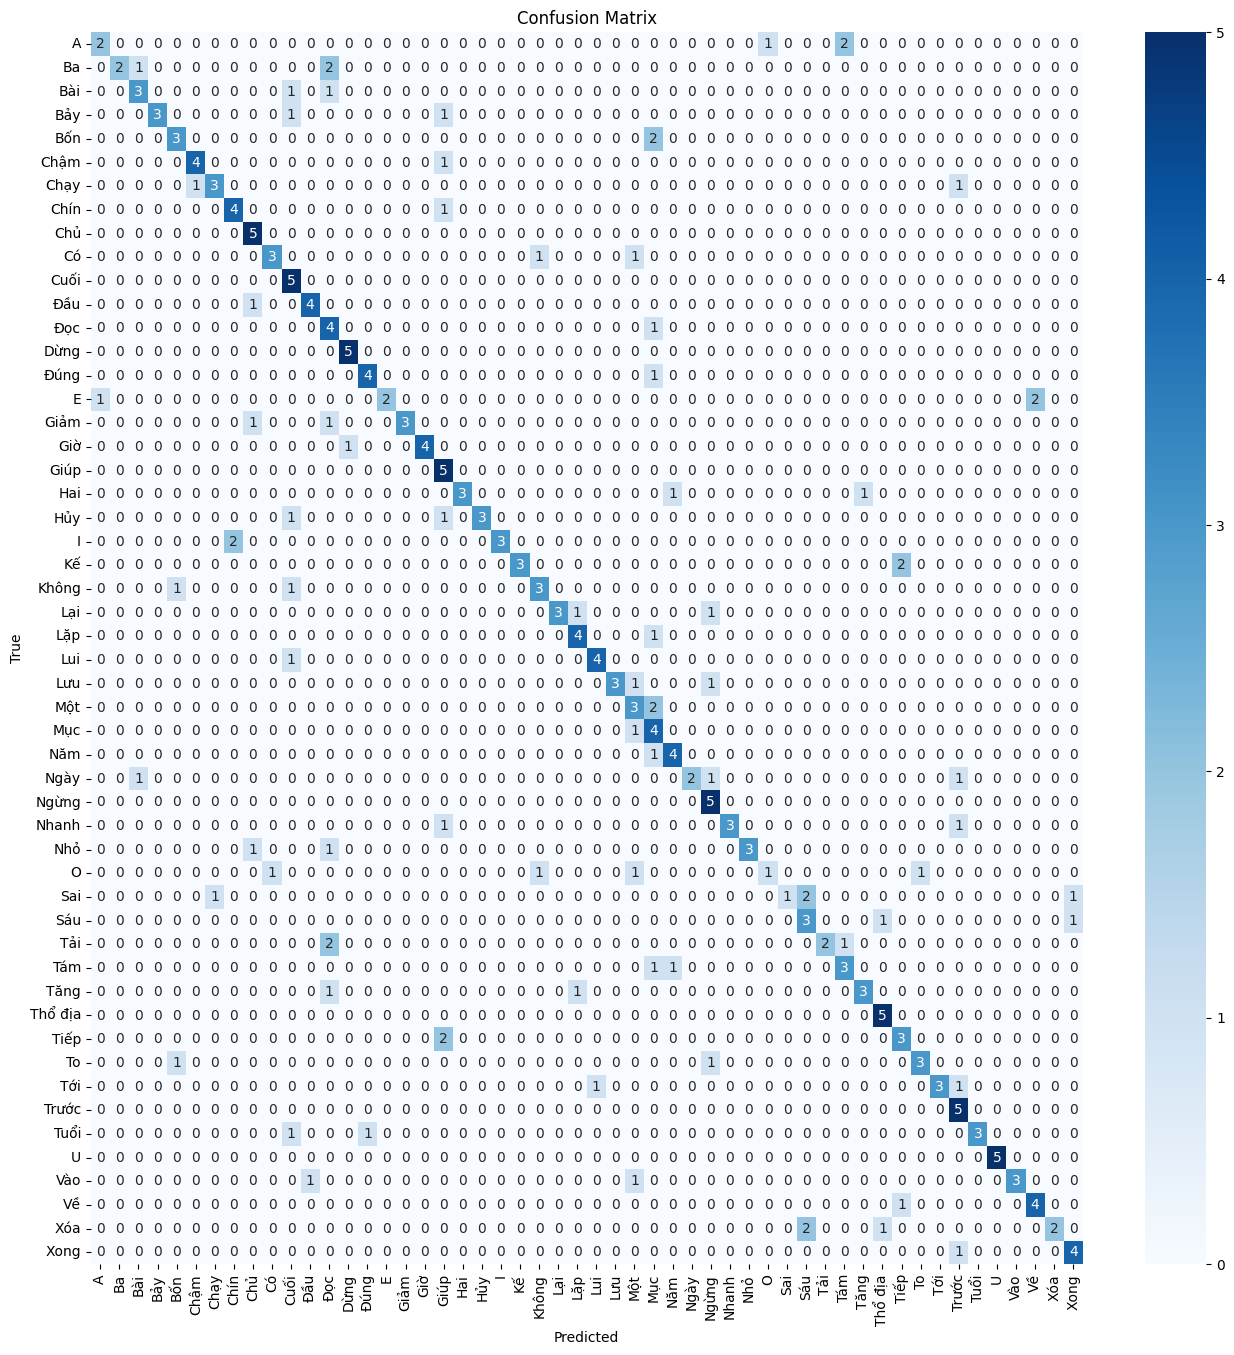

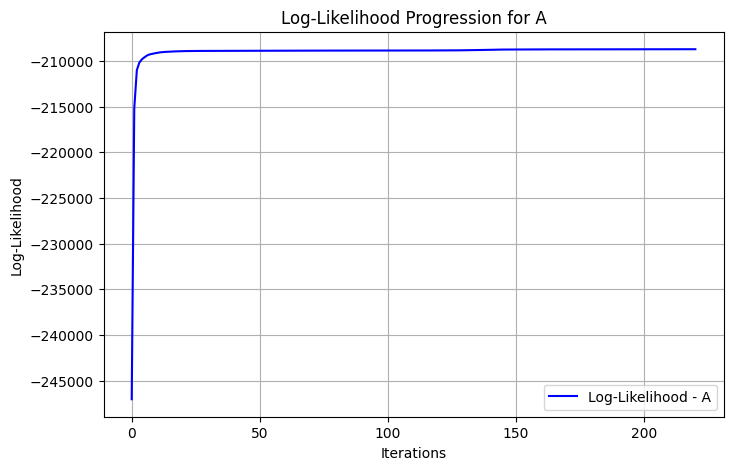

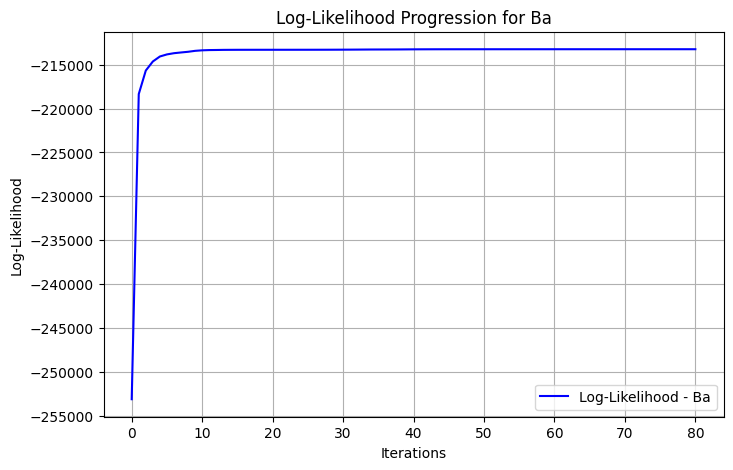

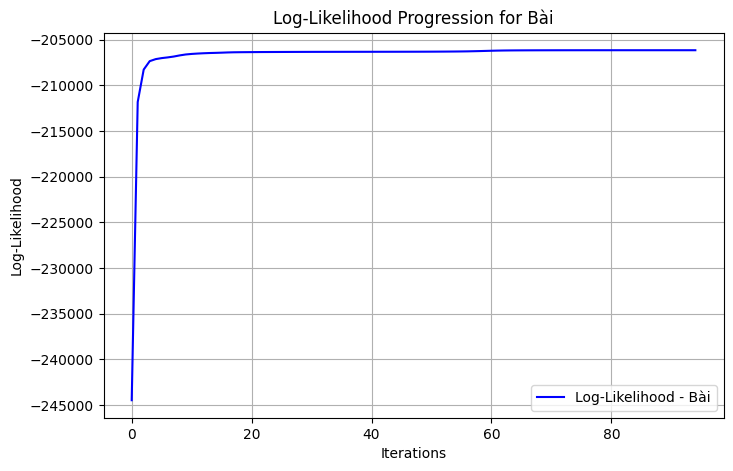

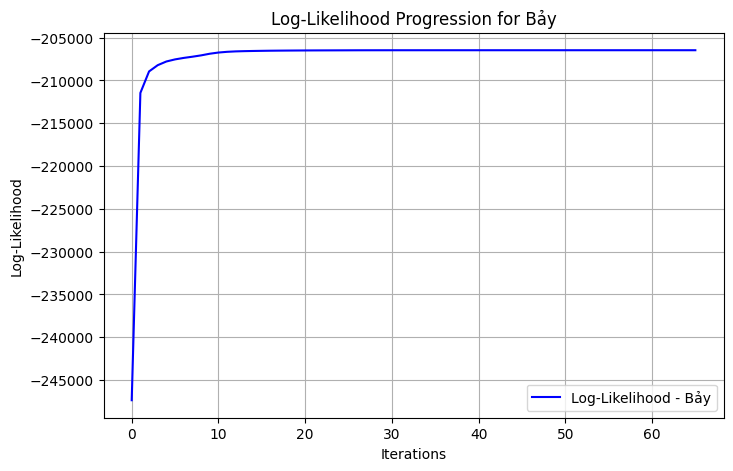

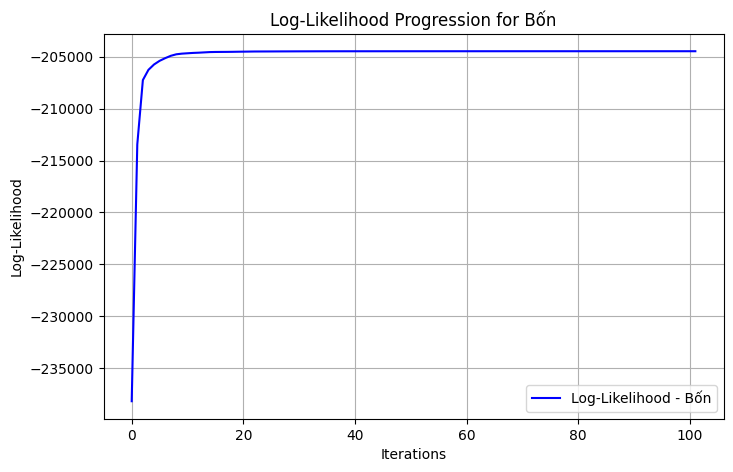

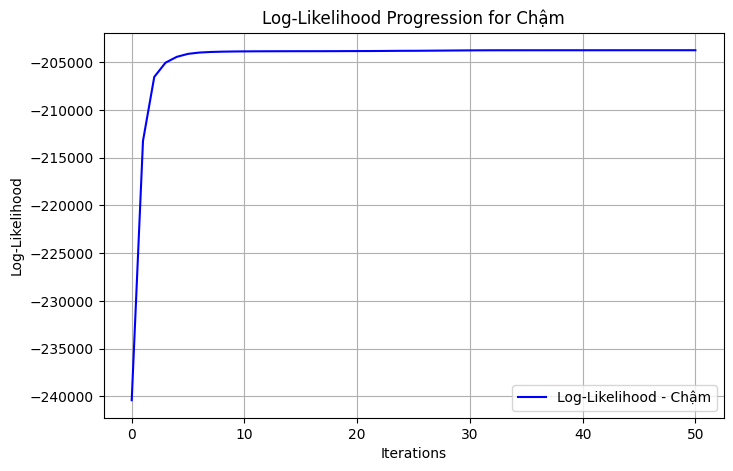

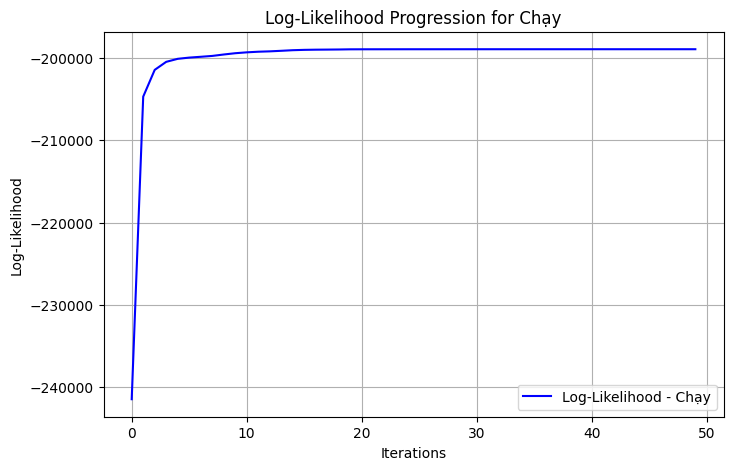

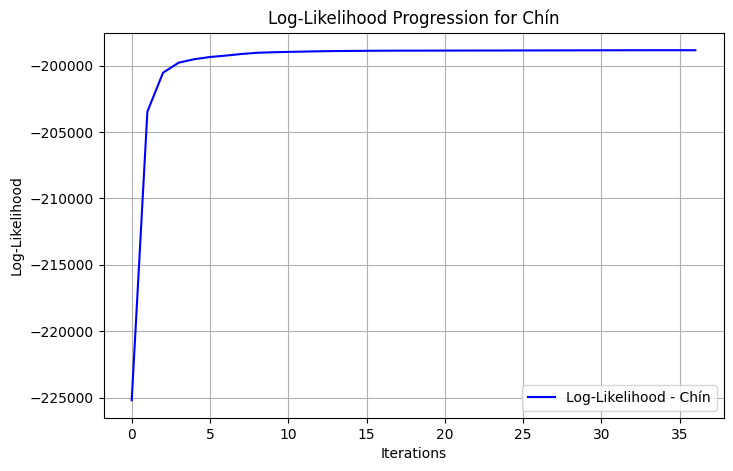

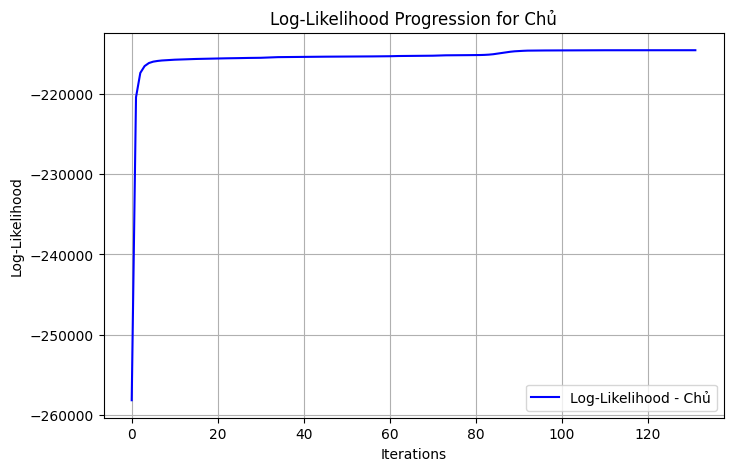

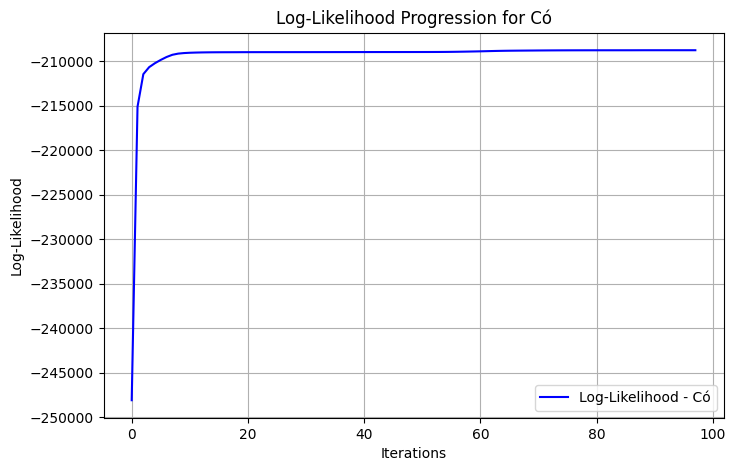

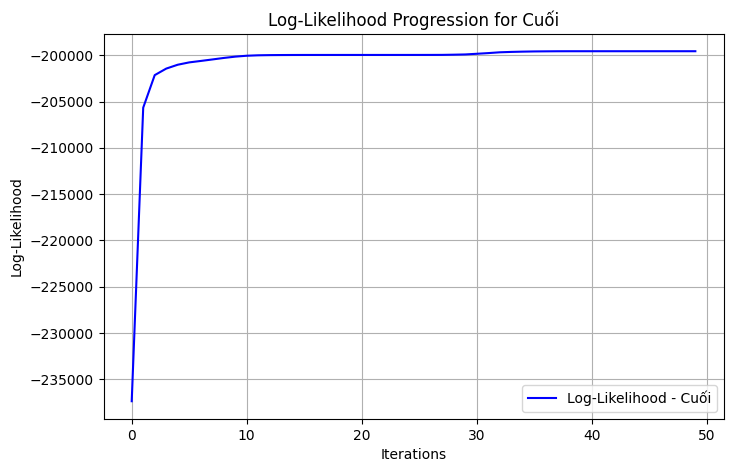

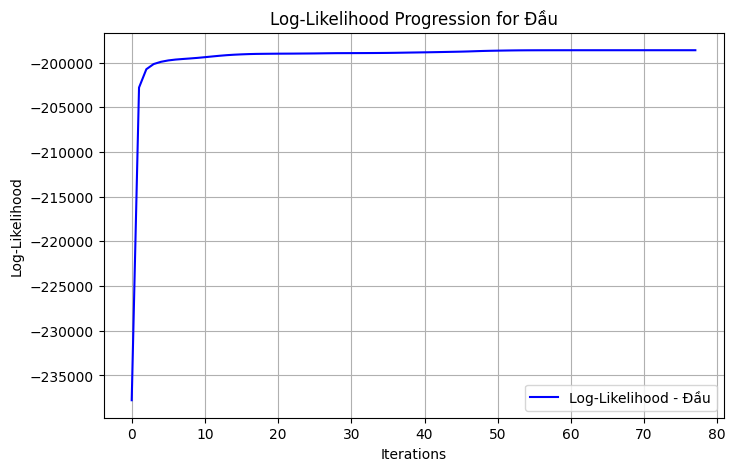

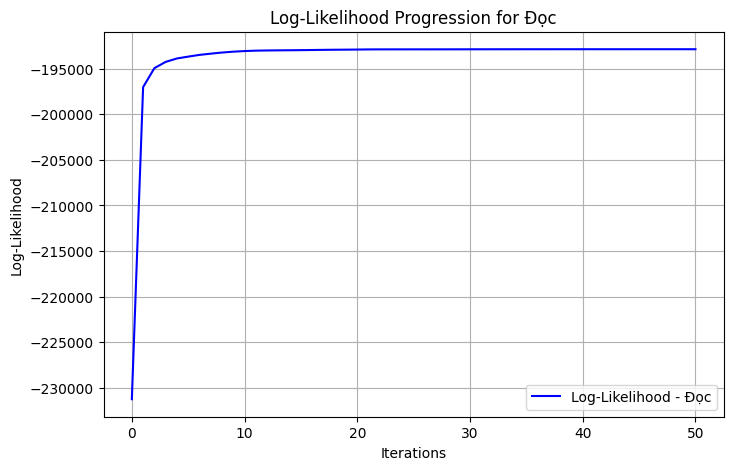

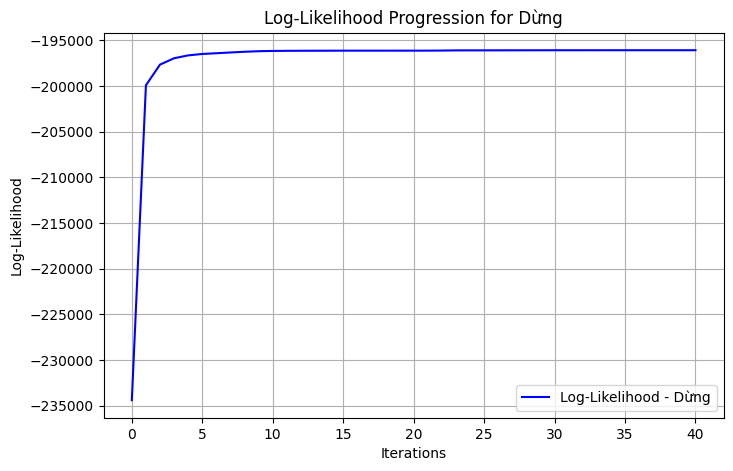

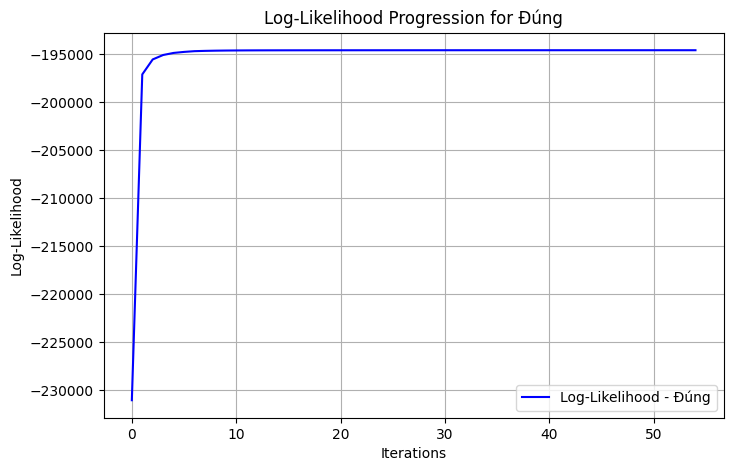

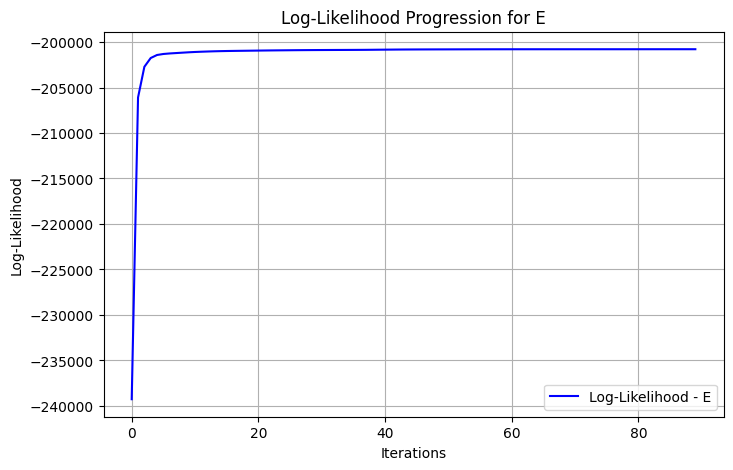

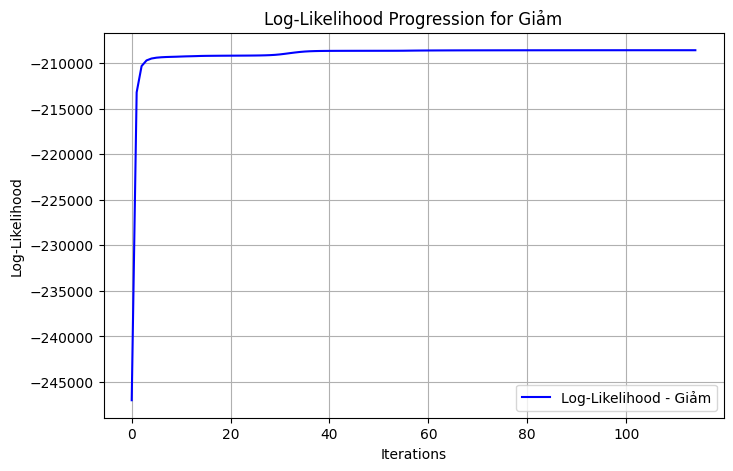

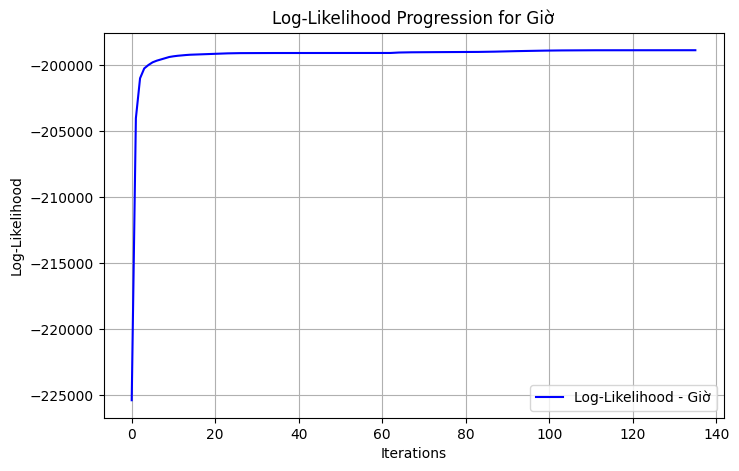

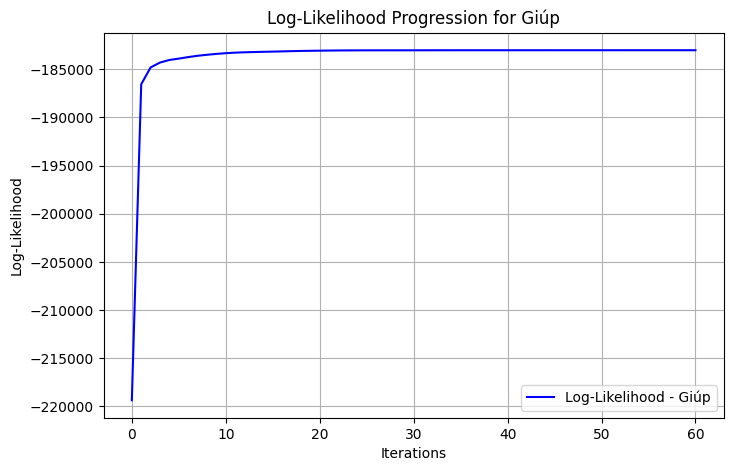

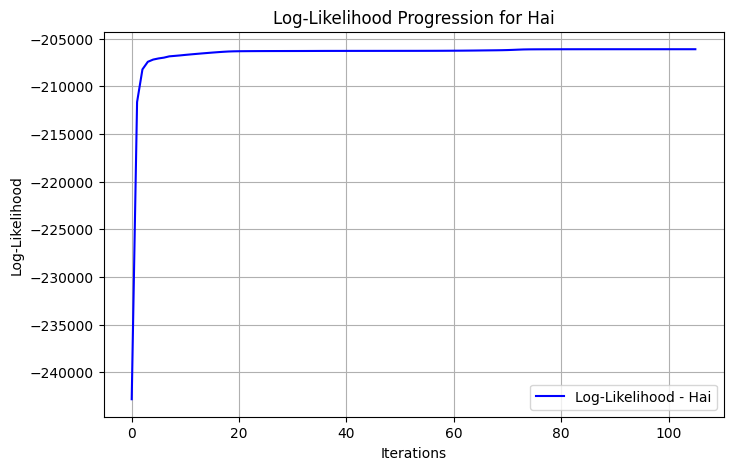

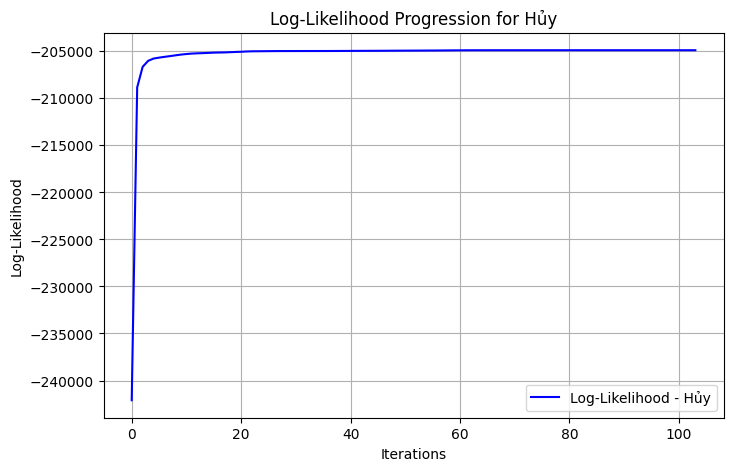

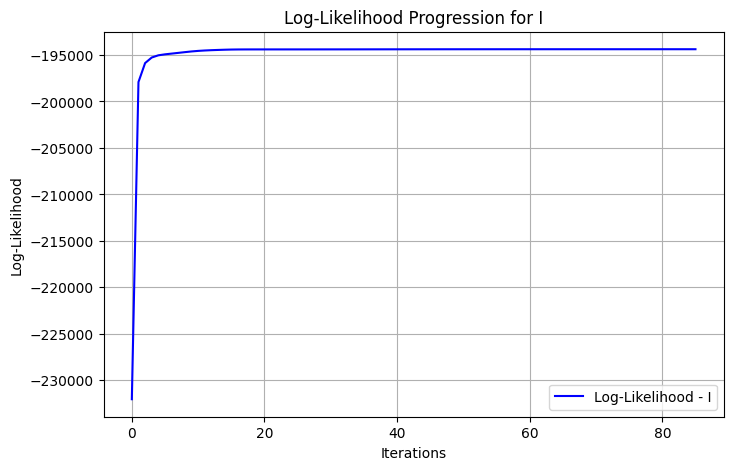

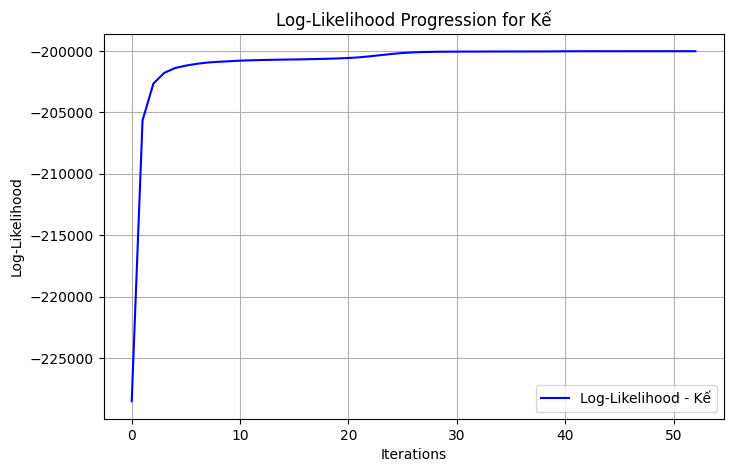

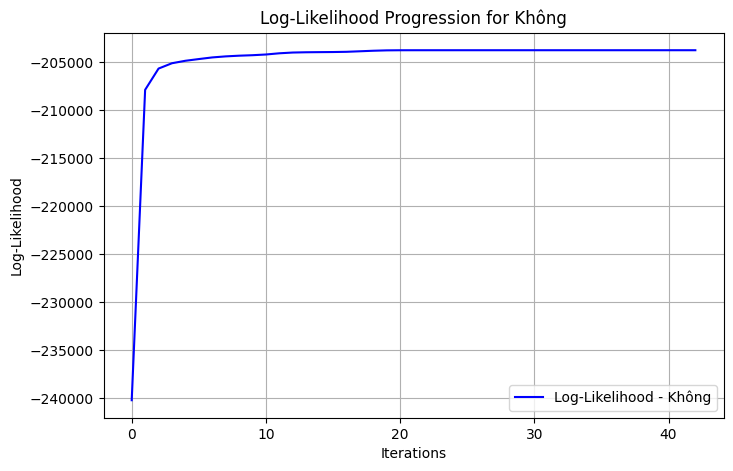

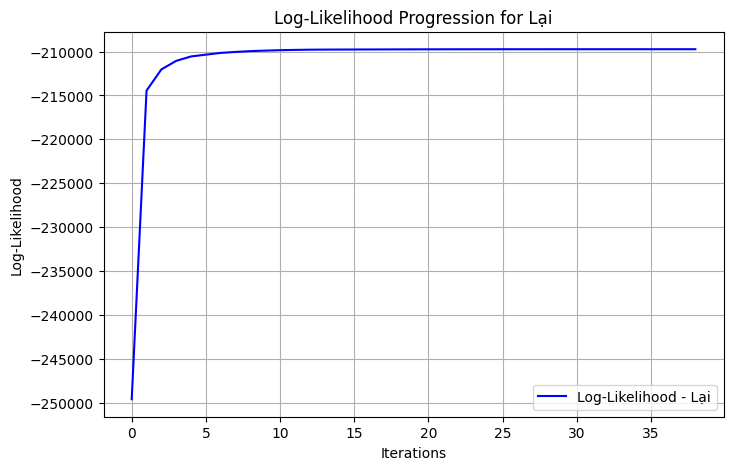

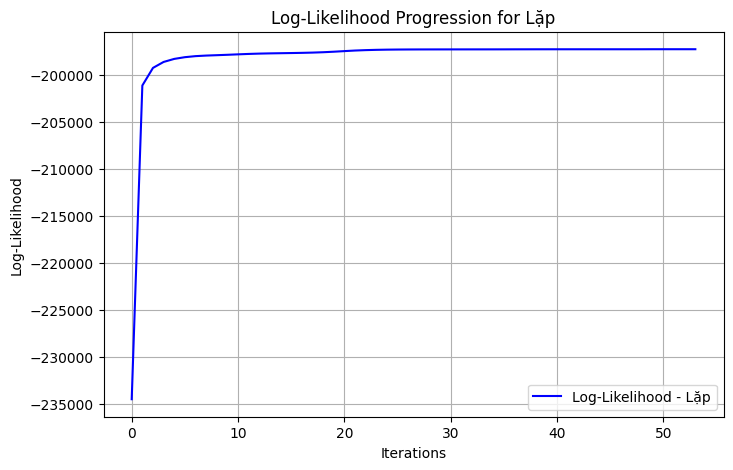

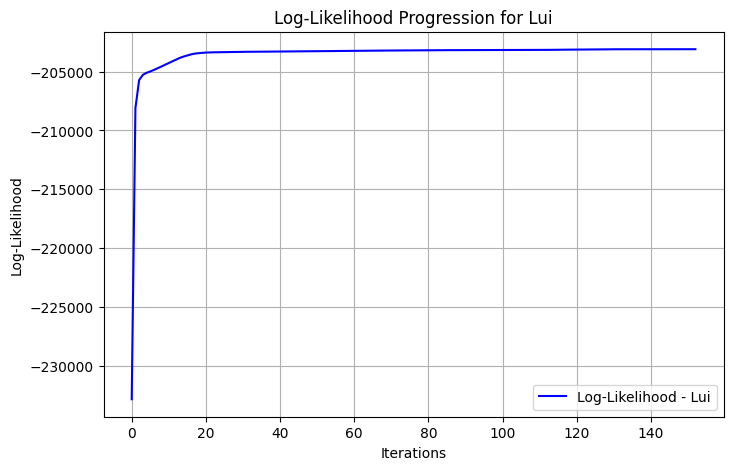

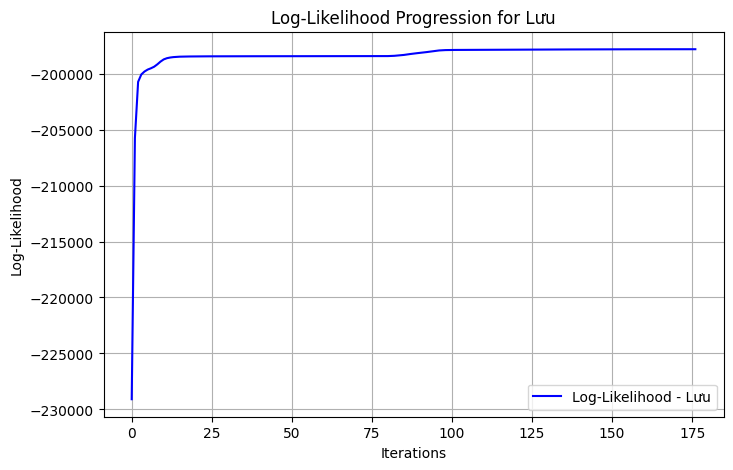

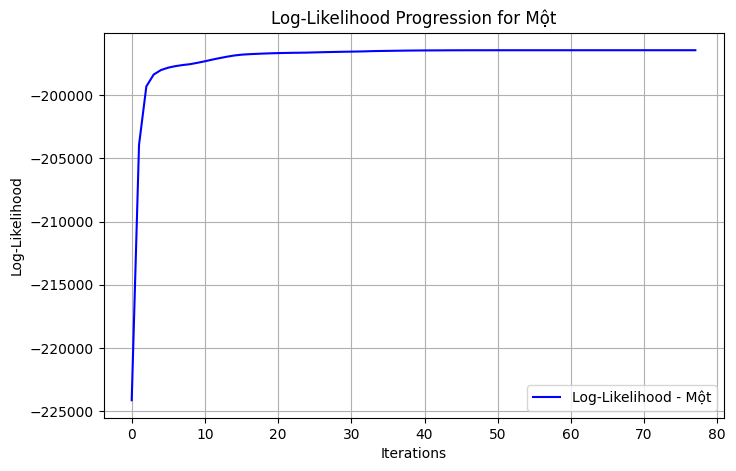

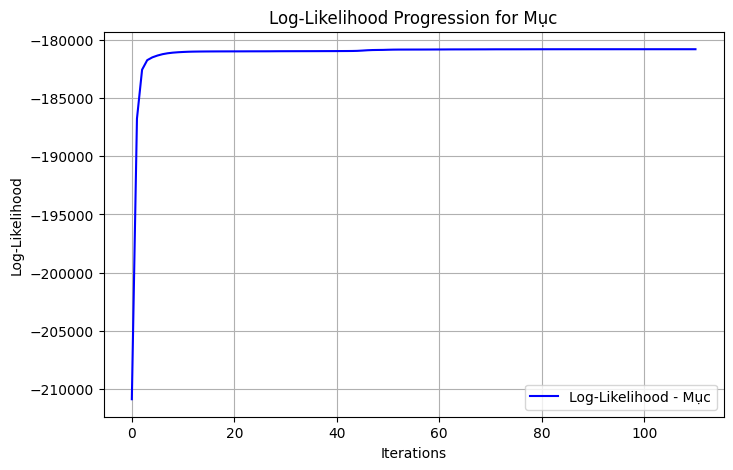

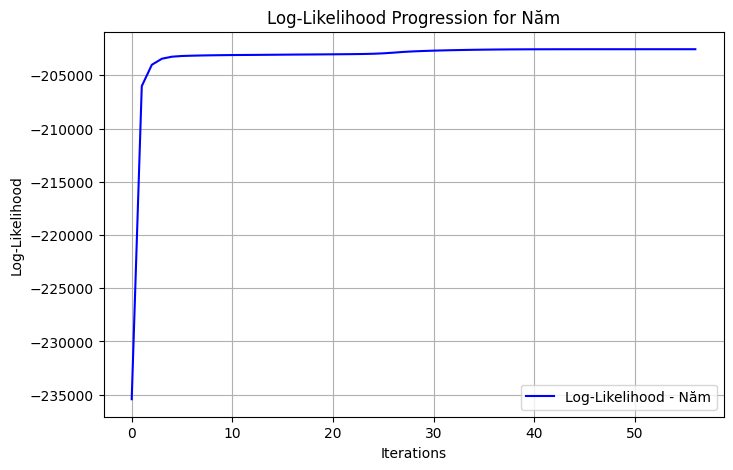

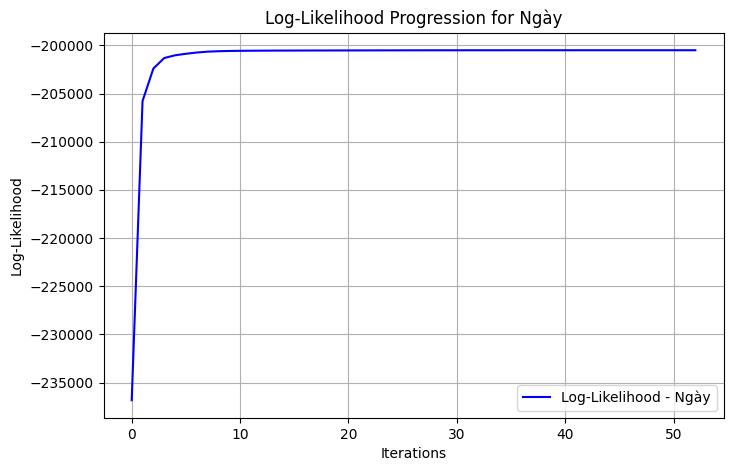

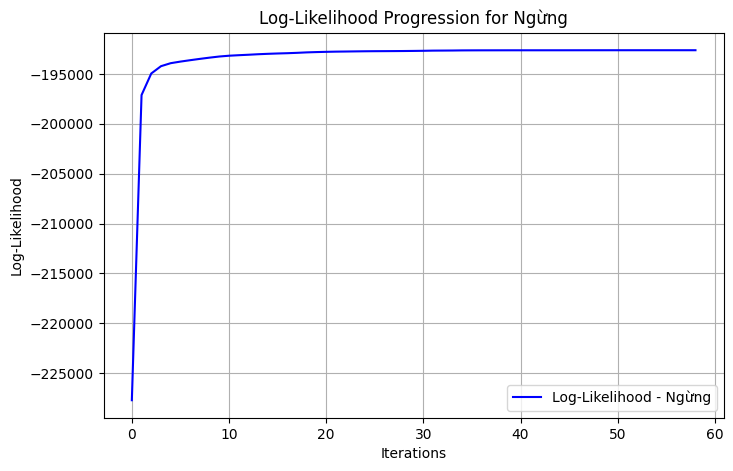

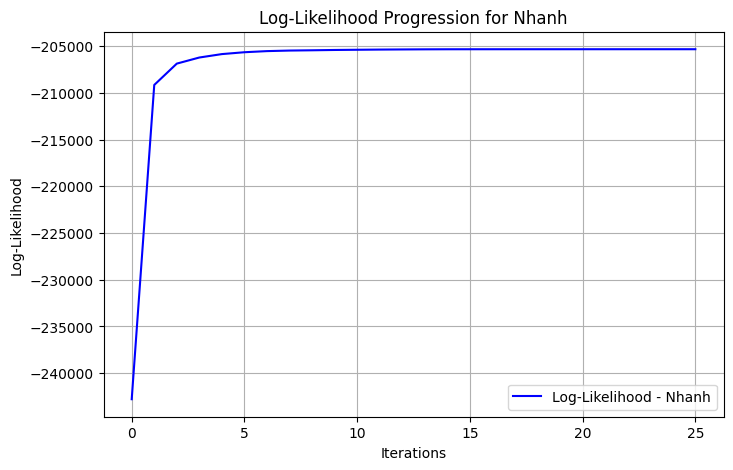

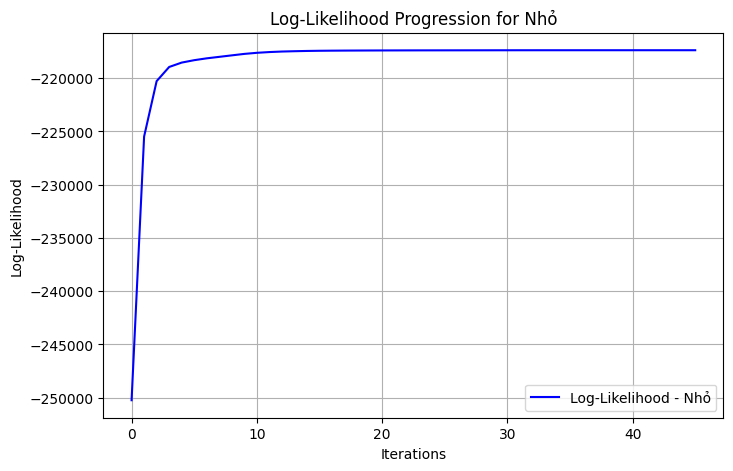

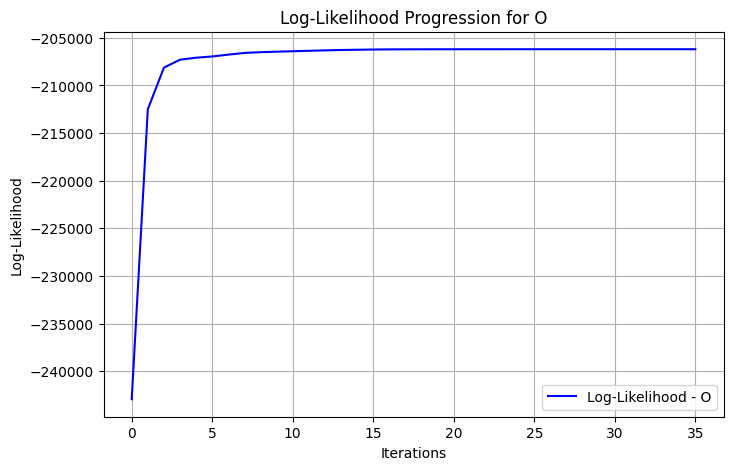

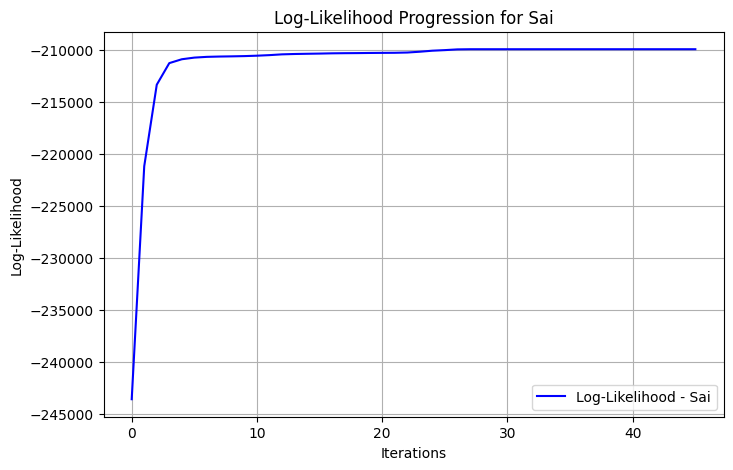

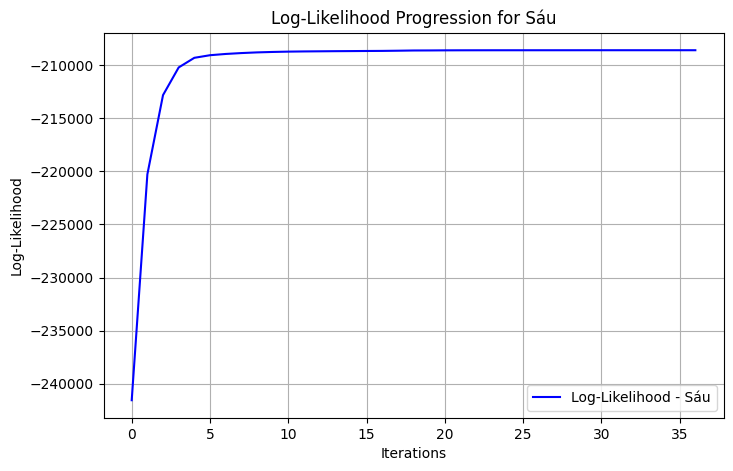

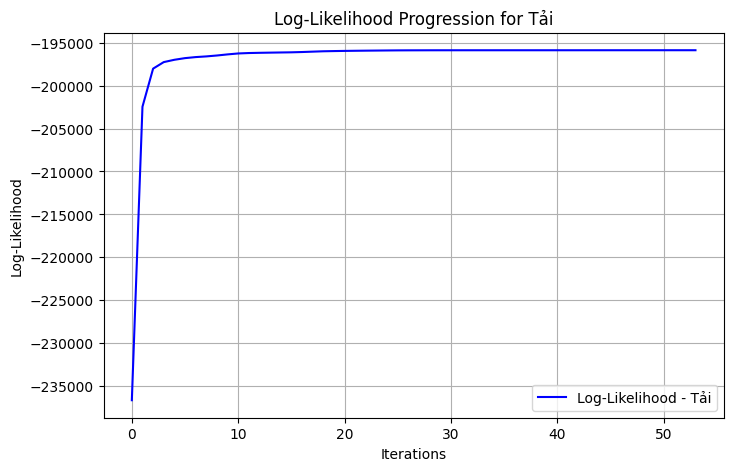

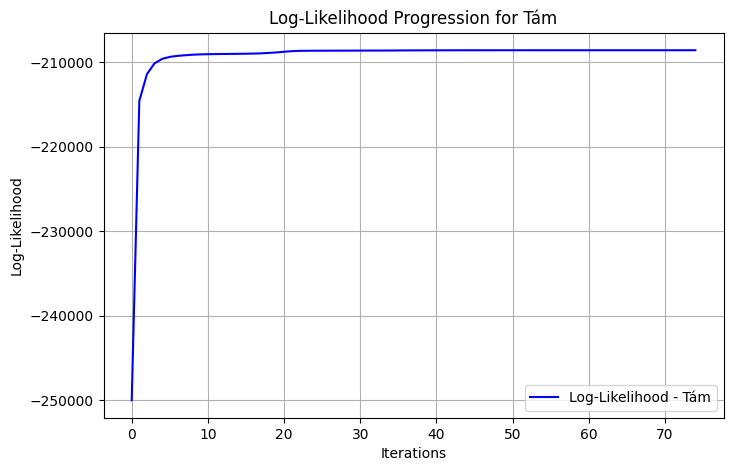

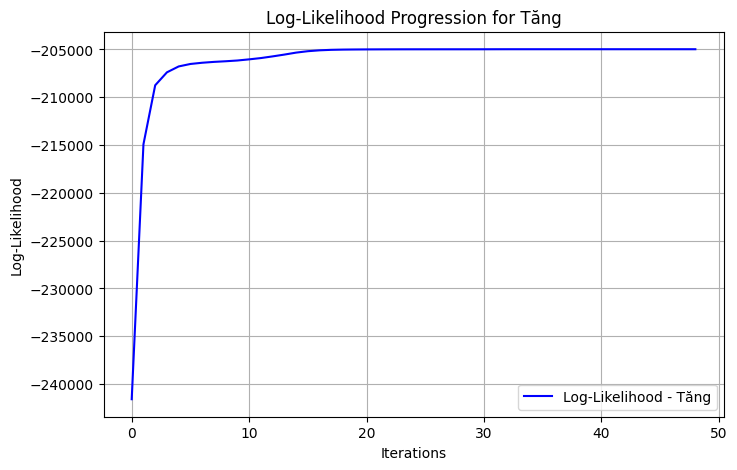

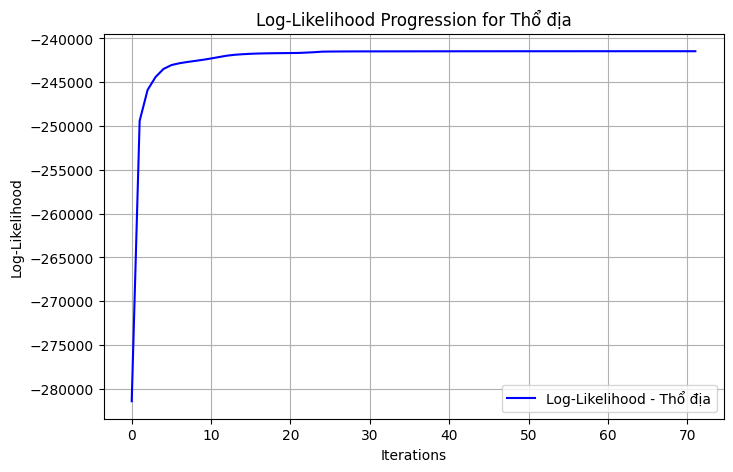

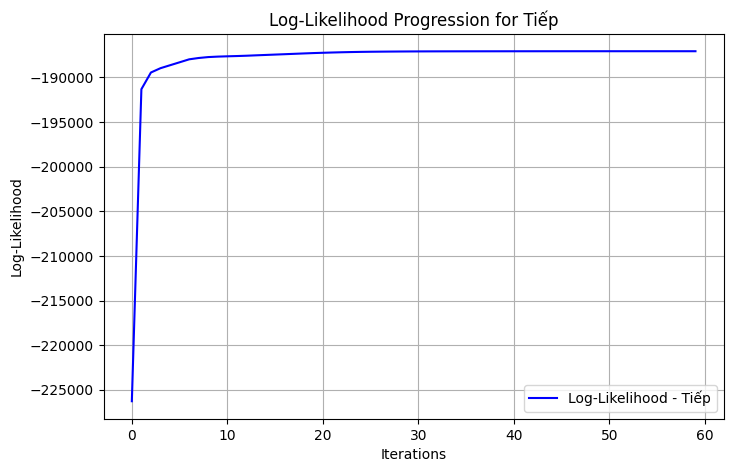

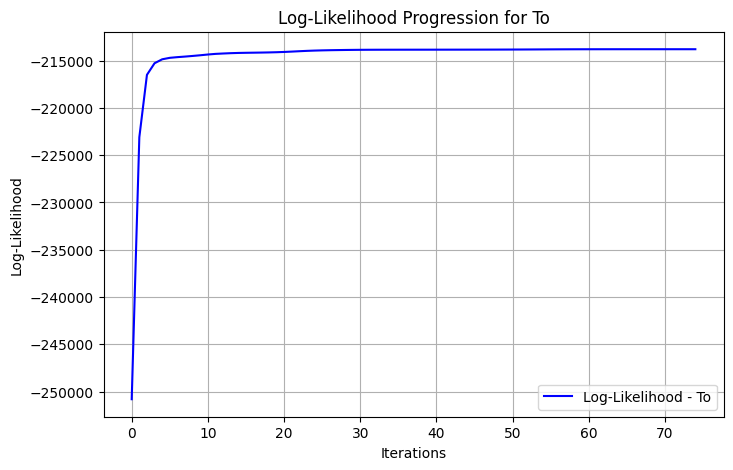

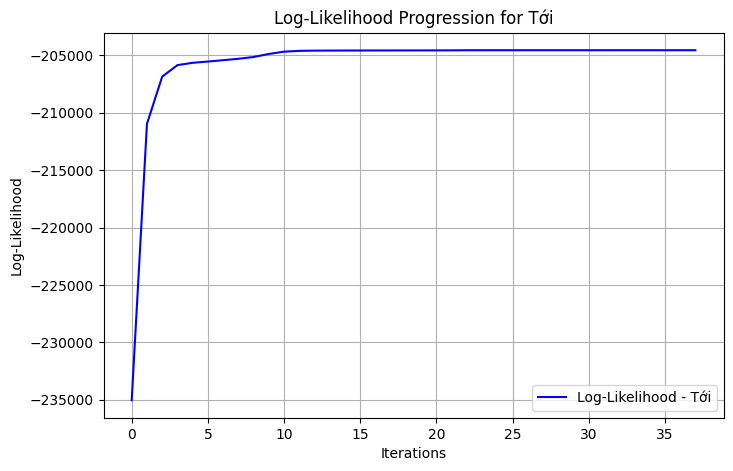

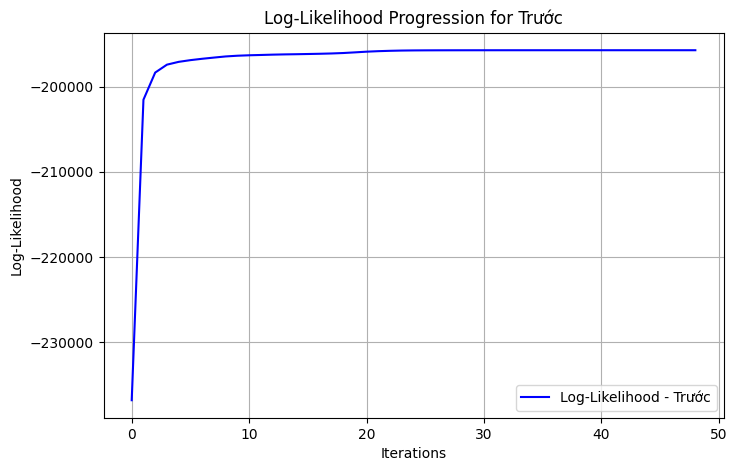

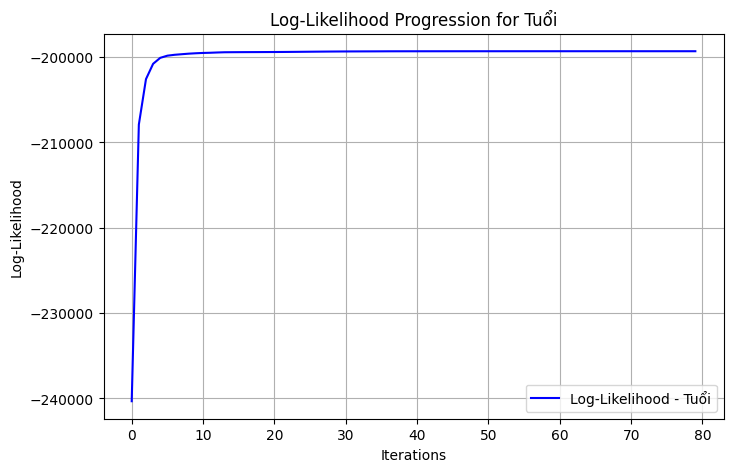

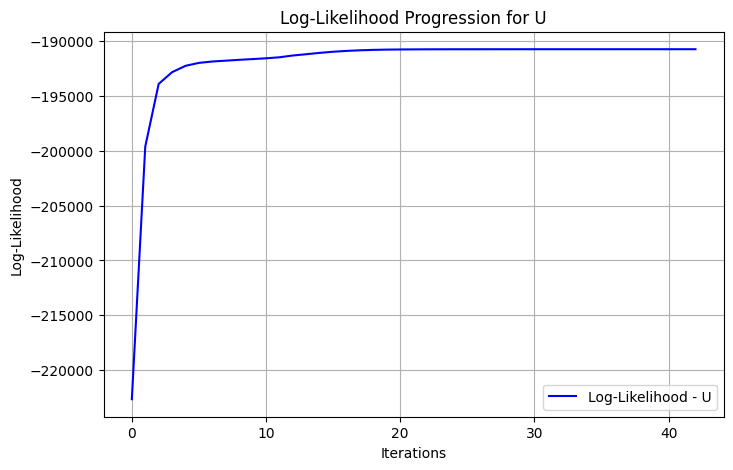

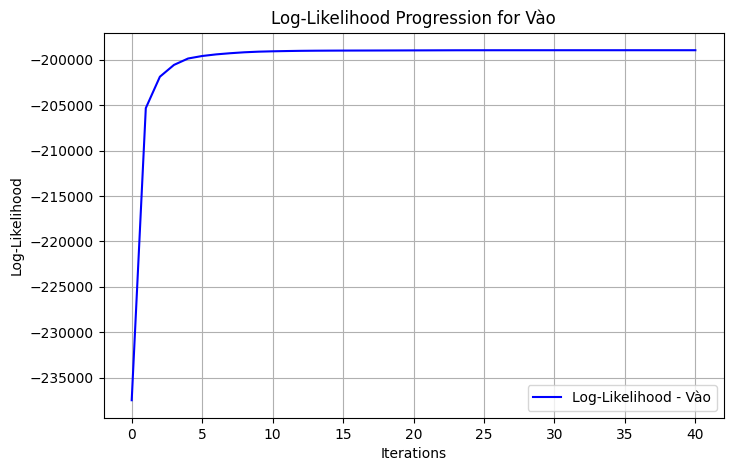

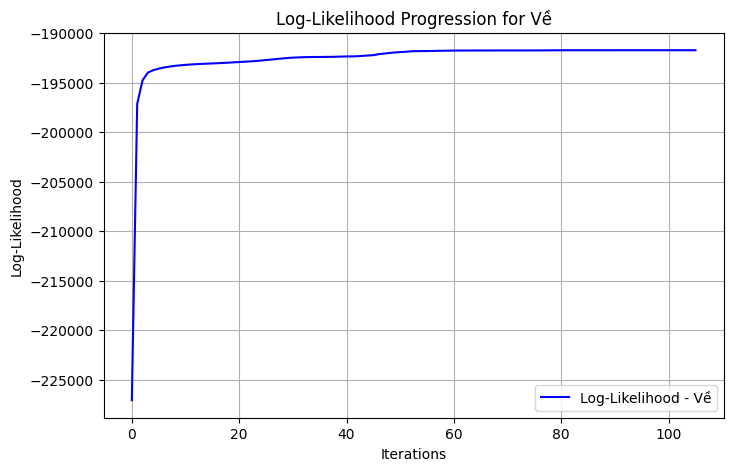

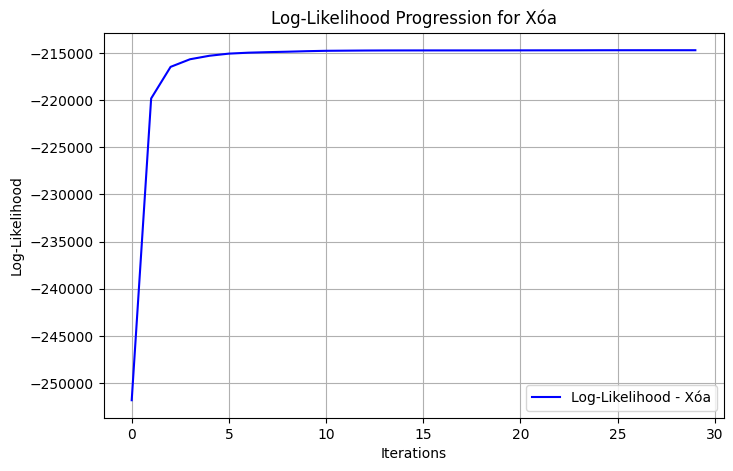

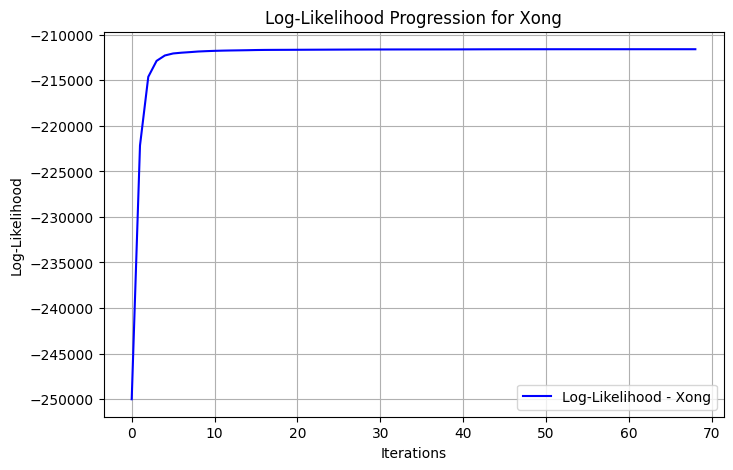

In [18]:
if __name__ == '__main__':
    hmm_train = HMMTraining()
    hmm_train.train()
    hmm_train.save_model()
    hmm_train.evaluation()
    hmm_train.plot_log_likelihood()